In [1]:
import os
import pandas as pd
from scipy.stats import linregress
import scipy as sts
import scipy.stats as st
import seaborn as sns
import numpy as np
import pylab as pl
import plotly.express as px
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.cbook as cbook
from matplotlib.ticker import FuncFormatter
import datetime as datetime
import gmaps
import requests
import json
#%matplotlib notebook
import warnings
warnings.filterwarnings("ignore")

In [2]:
world_df= pd.read_csv("../Resources/owid-covid-data.csv")

#Unsing total_deaths column and total_cases_per_million, total cases, new cases
updated_world_df=world_df.drop(["iso_code","new_deaths_per_million","total_tests","new_tests",
                                "new_tests_smoothed_per_thousand","population","median_age","aged_70_older",
                                "extreme_poverty","female_smokers","male_smokers",
                               "handwashing_facilities","hospital_beds_per_thousand","life_expectancy",
                               "new_tests_smoothed","new_tests_per_thousand","tests_units",
                               "new_deaths","new_cases_per_million"], axis=1)

updated_world_df=updated_world_dfupdated_world_df=updated_world_df.rename(columns={"location":"Country", "continent":"Continent","date":"Date",
                                                    "total_cases":"Total Cases", "new_cases":"New Cases",
                                                    "total_cases_per_million": "Total Cases Per Million",
                                                  "total_deaths_per_million":"Total Deaths Per Million",
                                                  "total_tests_per_thousand":"Total Test Per Thousands",
                                                 "population_density":"Population Density","aged_65_older":"Aged 65 or older",
                                                 "gdp_per_capita":"GDP Per Capita","cvd_death_rate":"Covid Death Rate",
                                                 "stringency_index":"Stringency Index","total_deaths":"Total Deaths"})

#updated_world_df.fillna(0, inplace=True)

updated_world_df.head()

Continent      Country        Date  Total Cases  New Cases  Total Deaths  \
0      Asia  Afghanistan  2019-12-31          0.0        0.0           0.0   
1      Asia  Afghanistan  2020-01-01          0.0        0.0           0.0   
2      Asia  Afghanistan  2020-01-02          0.0        0.0           0.0   
3      Asia  Afghanistan  2020-01-03          0.0        0.0           0.0   
4      Asia  Afghanistan  2020-01-04          0.0        0.0           0.0   

   Total Cases Per Million  Total Deaths Per Million  \
0                      0.0                       0.0   
1                      0.0                       0.0   
2                      0.0                       0.0   
3                      0.0                       0.0   
4                      0.0                       0.0   

   Total Test Per Thousands  Stringency Index  Population Density  \
0                       NaN               NaN              54.422   
1                       NaN               0.0              54.422   
2                       NaN               0.0              54.422   
3                       NaN               0.0              54.422   
4                       NaN               0.0              54.422   

   Aged 65 or older  GDP Per Capita  Covid Death Rate  diabetes_prevalence  
0             2.581        1803.987           597.029                 9.59  
1             2.581        1803.987           597.029                 9.59  
2             2.581        1803.987           597.029                 9.59  
3             2.581        1803.987           597.029                 9.59  
4             2.581        1803.987           597.029                 9.59

In [3]:
#Number Hospital Beds is based on the lastest year per Country

data = pd.read_csv("../Resources/data.csv")

who_df = data.iloc[data.groupby("Country")["Year"].agg(pd.Series.idxmax)]
who_df.reset_index(drop=True).set_index("Country")
who_df=who_df.rename(columns={"Hospital beds (per 10 000 population)":"Hospital Beds (per 10K people)"})
hospital_beds_df=who_df.drop(["Year"], axis=1)

hospital_beds_df.head()

Country  Hospital Beds (per 10K people)
0           Afghanistan                               5
16              Albania                              29
29              Algeria                              19
31               Angola                               8
32  Antigua and Barbuda                              38

In [4]:
#Smoking Percentage is based on the lastest year per Country

smokingdata = pd.read_csv("../Resources/smokingdata.csv")

smokingdata_df = smokingdata.iloc[smokingdata.groupby("Country")["Year"].agg(pd.Series.idxmax)]

clean_smoking_data = smokingdata_df.drop(["Estimate of current cigarette smoking prevalence (%).1", "Estimate of current cigarette smoking prevalence (%).2", 
                                       "Estimate of current tobacco smoking prevalence (%)", "Estimate of current tobacco smoking prevalence (%).1", 
                                       "Estimate of current tobacco smoking prevalence (%).2", "Estimate of current tobacco use prevalence (%)", 
                                       "Estimate of current tobacco use prevalence (%).1", "Estimate of current tobacco use prevalence (%).2"], axis=1)

 
clean_smoking_data=clean_smoking_data.rename(columns={"Estimate of current cigarette smoking prevalence (%)":"Smoking Prevalence (%)"})
smoking_data = clean_smoking_data
smoking_prevalence=list(smoking_data["Smoking Prevalence (%)"])
smoking_percentage=[]

for x in smoking_prevalence:
    y=x.split("[")
    smoking_percentage.append(y[0])
    

    
column_values = pd.Series(smoking_percentage)
smoking_data.insert(loc=2, column="Smoking Percetage", value=column_values)
smoking_year_df=smoking_data.drop(["Smoking Prevalence (%)"], axis=1)

smoking_df=smoking_year_df.drop(["Year"], axis=1)

smoking_df.head()

Country Smoking Percetage
1     Albania            11.20 
7     Algeria            15.20 
13    Andorra            21.40 
19  Argentina            31.40 
25    Armenia             6.00

In [5]:
world_df=pd.read_csv("../Resources/dsh_simple.csv")

world_df=world_df[["Countryname","IfclosedduetoCOVID19whend","Statusof Schoolsaresomeall (copy) (group)",
          "Latitude (generated)","Longitude (generated)","Incomelevelname"]]

income_level_df=world_df.rename(columns={"Countryname":"Country", "Latitude (generated)":"Latitude", 
                      "Longitude (generated)": "Longitude", "Incomelevelname": "Income Level",
                        "Statusof Schoolsaresomeall (copy) (group)":"School Status"})
income_df=income_level_df.drop(["IfclosedduetoCOVID19whend"], axis =1)

income_df.head()

Country School Status  Latitude  Longitude         Income Level
0        Eritrea        Closed   15.9820    38.0200           Low income
1  Guinea-Bissau        Closed   12.1910   -14.4750           Low income
2     San Marino        Closed   43.9420    12.4611          High income
3        Georgia        Closed   42.0500    43.5760  Upper middle income
4          Italy        Closed   44.3713    11.1084          High income

In [6]:
combined_df=pd.merge(updated_world_df,hospital_beds_df,on="Country",how="left").merge(smoking_df,on="Country",how="left" ).merge(income_df,on="Country",how="left")

combined_df.head()

Continent      Country        Date  Total Cases  New Cases  Total Deaths  \
0      Asia  Afghanistan  2019-12-31          0.0        0.0           0.0   
1      Asia  Afghanistan  2020-01-01          0.0        0.0           0.0   
2      Asia  Afghanistan  2020-01-02          0.0        0.0           0.0   
3      Asia  Afghanistan  2020-01-03          0.0        0.0           0.0   
4      Asia  Afghanistan  2020-01-04          0.0        0.0           0.0   

   Total Cases Per Million  Total Deaths Per Million  \
0                      0.0                       0.0   
1                      0.0                       0.0   
2                      0.0                       0.0   
3                      0.0                       0.0   
4                      0.0                       0.0   

   Total Test Per Thousands  Stringency Index  ...  Aged 65 or older  \
0                       NaN               NaN  ...             2.581   
1                       NaN               0.0  ...             2.581   
2                       NaN               0.0  ...             2.581   
3                       NaN               0.0  ...             2.581   
4                       NaN               0.0  ...             2.581   

   GDP Per Capita  Covid Death Rate  diabetes_prevalence  \
0        1803.987           597.029                 9.59   
1        1803.987           597.029                 9.59   
2        1803.987           597.029                 9.59   
3        1803.987           597.029                 9.59   
4        1803.987           597.029                 9.59   

   Hospital Beds (per 10K people)  Smoking Percetage School Status Latitude  \
0                             5.0                NaN        Closed   34.023   
1                             5.0                NaN        Closed   34.023   
2                             5.0                NaN        Closed   34.023   
3                             5.0                NaN        Closed   34.023   
4                             5.0                NaN        Closed   34.023   

   Longitude  Income Level  
0    65.5267    Low income  
1    65.5267    Low income  
2    65.5267    Low income  
3    65.5267    Low income  
4    65.5267    Low income  

[5 rows x 21 columns]

In [7]:
#DATA CLEANING

strigency_per_country = combined_df[["Country","Date","Total Cases","Total Cases Per Million",
                                     "New Cases","Total Deaths Per Million",
                                     "Total Deaths","Stringency Index",
                                     "GDP Per Capita","Income Level",
                                    "Continent"]]
strigency_per_country.fillna(0, inplace=True)

#countries without Stringency Index and Number of Tests
no_stringency = strigency_per_country.groupby(["Country"]).mean()
no_stringency_countries = no_stringency[no_stringency["Stringency Index"] == 0].copy()
no_stringency_country_list = no_stringency_countries.index.tolist().copy()

#remove from list countries withouth Stringency Index and Number of Tests
for country in no_stringency_country_list:
    index = strigency_per_country[strigency_per_country["Country"] == country].index.copy()
    strigency_per_country.drop(index, inplace = True)

strigency_per_country.head(5)    

Country        Date  Total Cases  Total Cases Per Million  New Cases  \
0  Afghanistan  2019-12-31          0.0                      0.0        0.0   
1  Afghanistan  2020-01-01          0.0                      0.0        0.0   
2  Afghanistan  2020-01-02          0.0                      0.0        0.0   
3  Afghanistan  2020-01-03          0.0                      0.0        0.0   
4  Afghanistan  2020-01-04          0.0                      0.0        0.0   

   Total Deaths Per Million  Total Deaths  Stringency Index  GDP Per Capita  \
0                       0.0           0.0               0.0        1803.987   
1                       0.0           0.0               0.0        1803.987   
2                       0.0           0.0               0.0        1803.987   
3                       0.0           0.0               0.0        1803.987   
4                       0.0           0.0               0.0        1803.987   

  Income Level Continent  
0   Low income      Asia  
1   Low income      Asia  
2   Low income      Asia  
3   Low income      Asia  
4   Low income      Asia

In [8]:
#Drop San Marino From Data Frame
strigency_per_country_f = strigency_per_country[strigency_per_country["Country"] != "San Marino"]

strigency_per_country_f 

Country        Date  Total Cases  Total Cases Per Million  \
0      Afghanistan  2019-12-31          0.0                    0.000   
1      Afghanistan  2020-01-01          0.0                    0.000   
2      Afghanistan  2020-01-02          0.0                    0.000   
3      Afghanistan  2020-01-03          0.0                    0.000   
4      Afghanistan  2020-01-04          0.0                    0.000   
...            ...         ...          ...                      ...   
25253     Zimbabwe  2020-06-18        401.0                   26.980   
25254     Zimbabwe  2020-06-19        463.0                   31.151   
25255     Zimbabwe  2020-06-20        479.0                   32.228   
25256     Zimbabwe  2020-06-21        486.0                   32.699   
25257     Zimbabwe  2020-06-22        489.0                   32.901   

       New Cases  Total Deaths Per Million  Total Deaths  Stringency Index  \
0            0.0                     0.000           0.0               0.0   
1            0.0                     0.000           0.0               0.0   
2            0.0                     0.000           0.0               0.0   
3            0.0                     0.000           0.0               0.0   
4            0.0                     0.000           0.0               0.0   
...          ...                       ...           ...               ...   
25253        7.0                     0.269           4.0               0.0   
25254       62.0                     0.269           4.0               0.0   
25255       16.0                     0.269           4.0               0.0   
25256        7.0                     0.404           6.0               0.0   
25257        3.0                     0.404           6.0               0.0   

       GDP Per Capita         Income Level Continent  
0            1803.987           Low income      Asia  
1            1803.987           Low income      Asia  
2            1803.987           Low income      Asia  
3            1803.987           Low income      Asia  
4            1803.987           Low income      Asia  
...               ...                  ...       ...  
25253        1899.775  Lower middle income    Africa  
25254        1899.775  Lower middle income    Africa  
25255        1899.775  Lower middle income    Africa  
25256        1899.775  Lower middle income    Africa  
25257        1899.775  Lower middle income    Africa  

[21504 rows x 11 columns]

In [9]:
max_stringency = strigency_per_country_f .groupby("Country").agg({"Stringency Index":"max"})
max_total_deaths_permillion = strigency_per_country_f .groupby("Country").agg({"Total Deaths Per Million":"max"})
max_total_deaths = strigency_per_country_f .groupby("Country").agg({"Total Deaths":"max"})
max_total_cases = strigency_per_country_f .groupby("Country").agg({"Total Cases Per Million":"max"})
income = strigency_per_country_f .groupby("Country").agg({"Income Level":"unique"})
continent = strigency_per_country_f .groupby("Country").agg({"Continent":"unique"})

combined_stringency = pd.merge(max_stringency,max_total_deaths_permillion,on="Country",how="inner").merge(income,on="Country",how="inner").merge(max_total_deaths, on="Country", how="left").merge(max_total_cases, on="Country", how="left").merge(continent, on="Country", how="left")

combined_stringency_df = combined_stringency[combined_stringency["Income Level"] != 0]
combined_stringency_df

income=[]
continent_list=[]
for index, row in combined_stringency_df.iterrows():
    x=row["Income Level"][0]
    y=row["Continent"][0]
    income.append(x)
    continent_list.append(y)
    
combined_stringency_df["Country Income Level"]=income
combined_stringency_df["Continents"]=continent_list   
    
combined_stg_df = combined_stringency_df.reset_index()
combined_stg_df.head()


Country  Stringency Index  Total Deaths Per Million  \
0  Afghanistan             84.26                    14.925   
1      Albania             89.81                    15.289   
2      Algeria             92.13                    19.270   
3       Angola             90.74                     0.274   
4    Argentina            100.00                    22.369   

            Income Level  Total Deaths  Total Cases Per Million  \
0           [Low income]         581.0                  740.669   
1  [Upper middle income]          44.0                  669.609   
2  [Upper middle income]         845.0                  268.431   
3  [Lower middle income]           9.0                    5.355   
4  [Upper middle income]        1011.0                  946.372   

         Continent Country Income Level     Continents  
0           [Asia]           Low income           Asia  
1         [Europe]  Upper middle income         Europe  
2         [Africa]  Upper middle income         Africa  
3         [Africa]  Lower middle income         Africa  
4  [South America]  Upper middle income  South America

In [10]:
#COUNTRIES WITH HIGHEST STRINGENCY INDEXES
sorted_stg = combined_stg_df.sort_values("Stringency Index",ascending=False )
sorted_stg.head(15)

Country  Stringency Index  Total Deaths Per Million  \
73               Kuwait            100.00                    76.337   
59             Honduras            100.00                    36.650   
107         Philippines            100.00                    10.668   
125           Sri Lanka            100.00                     0.514   
39             Djibouti            100.00                    45.546   
43          El Salvador            100.00                    16.497   
51              Georgia            100.00                     3.509   
78                Libya            100.00                     1.455   
116              Serbia            100.00                    38.356   
62                India            100.00                     9.927   
70               Jordan            100.00                     0.882   
4             Argentina            100.00                    22.369   
110         Puerto Rico             97.22                    52.083   
41   Dominican Republic             97.22                    61.026   
55            Guatemala             96.30                    29.639   

              Income Level  Total Deaths  Total Cases Per Million  \
73           [High income]         326.0                 9284.490   
59   [Lower middle income]         363.0                 1289.198   
107  [Lower middle income]        1169.0                  274.244   
125  [Upper middle income]          11.0                   91.065   
39   [Lower middle income]          45.0                 4637.642   
43   [Lower middle income]         107.0                  713.206   
51   [Upper middle income]          14.0                  227.616   
78   [Upper middle income]          10.0                   79.170   
116  [Upper middle income]         261.0                 1894.896   
62   [Lower middle income]       13699.0                  308.174   
70   [Upper middle income]           9.0                  101.243   
4    [Upper middle income]        1011.0                  946.372   
110          [High income]         149.0                 2280.799   
41   [Upper middle income]         662.0                 2459.185   
55   [Upper middle income]         531.0                  733.719   

           Continent Country Income Level     Continents  
73            [Asia]          High income           Asia  
59   [North America]  Lower middle income  North America  
107           [Asia]  Lower middle income           Asia  
125           [Asia]  Upper middle income           Asia  
39          [Africa]  Lower middle income         Africa  
43   [North America]  Lower middle income  North America  
51            [Asia]  Upper middle income           Asia  
78          [Africa]  Upper middle income         Africa  
116         [Europe]  Upper middle income         Europe  
62            [Asia]  Lower middle income           Asia  
70            [Asia]  Upper middle income           Asia  
4    [South America]  Upper middle income  South America  
110  [North America]          High income  North America  
41   [North America]  Upper middle income  North America  
55   [North America]  Upper middle income  North America

In [11]:
#COUNTRIES WITH LOWEST STRINGENCY INDEXES
sorted_stg = combined_stg_df.sort_values("Stringency Index")
sorted_stg.head(5)

Country  Stringency Index  Total Deaths Per Million  \
97   Nicaragua             16.67                     9.661   
12     Belarus             19.44                    36.616   
24     Burundi             22.22                     0.084   
128     Sweden             46.30                   500.333   
69       Japan             47.22                     7.535   

              Income Level  Total Deaths  Total Cases Per Million  \
97   [Lower middle income]          64.0                  304.020   
12   [Upper middle income]         346.0                 6191.450   
24            [Low income]           1.0                   12.110   
128          [High income]        5053.0                 5549.213   
69           [High income]         953.0                  141.655   

           Continent Country Income Level     Continents  
97   [North America]  Lower middle income  North America  
12          [Europe]  Upper middle income         Europe  
24          [Africa]           Low income         Africa  
128         [Europe]          High income         Europe  
69            [Asia]          High income           Asia

In [12]:
#COUNTRIES WITH HIGHEST TOTAL NUMBER OF DEATHS PER MILLION
top_totaldeaths_permillion =  sorted_stg[sorted_stg["Total Deaths Per Million"]>200]
top_totaldeaths_permillion_df = top_totaldeaths_permillion.sort_values(by=["Total Deaths Per Million"], ascending=False).reset_index(drop=True)
top_totaldeaths_permillion_df.head(10)

Country  Stringency Index  Total Deaths Per Million  \
0         Belgium             81.48                   836.611   
1  United Kingdom             75.93                   627.994   
2           Spain             85.19                   614.953   
3           Italy             93.52                   572.824   
4          Sweden             46.30                   500.333   
5          France             90.74                   454.089   
6   United States             72.69                   362.459   
7     Netherlands             79.63                   355.416   
8         Ireland             90.74                   347.321   
9            Peru             96.30                   243.996   

            Income Level  Total Deaths  Total Cases Per Million  \
0          [High income]        9696.0                 5224.504   
1          [High income]       42632.0                 4482.971   
2          [High income]       28752.0                 5267.311   
3          [High income]       34634.0                 3944.621   
4          [High income]        5053.0                 5549.213   
5          [High income]       29640.0                 2457.000   
6          [High income]      119975.0                 6890.918   
7          [High income]        6090.0                 2894.273   
8          [High income]        1715.0                 5139.743   
9  [Upper middle income]        8045.0                 7731.930   

         Continent Country Income Level     Continents  
0         [Europe]          High income         Europe  
1         [Europe]          High income         Europe  
2         [Europe]          High income         Europe  
3         [Europe]          High income         Europe  
4         [Europe]          High income         Europe  
5         [Europe]          High income         Europe  
6  [North America]          High income  North America  
7         [Europe]          High income         Europe  
8         [Europe]          High income         Europe  
9  [South America]  Upper middle income  South America

In [13]:
#COUNTRIES WITH HIGHEST TOTAL NUMBER OF DEATHS 
top_totaldeaths =  sorted_stg[sorted_stg["Total Deaths"]>7800]
top_totaldeaths_df = top_totaldeaths.sort_values(by=["Total Deaths"], ascending=False).reset_index(drop=True)
top_totaldeaths_df.head()

Country  Stringency Index  Total Deaths Per Million  \
0   United States             72.69                   362.459   
1          Brazil             81.02                   238.131   
2  United Kingdom             75.93                   627.994   
3           Italy             93.52                   572.824   
4          France             90.74                   454.089   

            Income Level  Total Deaths  Total Cases Per Million  \
0          [High income]      119975.0                 6890.918   
1  [Upper middle income]       50617.0                 5104.634   
2          [High income]       42632.0                 4482.971   
3          [High income]       34634.0                 3944.621   
4          [High income]       29640.0                 2457.000   

         Continent Country Income Level     Continents  
0  [North America]          High income  North America  
1  [South America]  Upper middle income  South America  
2         [Europe]          High income         Europe  
3         [Europe]          High income         Europe  
4         [Europe]          High income         Europe

In [14]:
#COUNTRIES WITH HIGHEST TOTAL CASES PER MILLION
top_cases_permillion =  sorted_stg[sorted_stg["Total Cases Per Million"]>5500]
top_cases_permillion_df = top_cases_permillion.sort_values(by=["Total Cases Per Million"], ascending=False).reset_index(drop=True)
top_cases_permillion_df

Country  Stringency Index  Total Deaths Per Million  \
0           Qatar             86.11                    34.015   
1         Bahrain             78.70                    37.024   
2           Chile             78.24                   234.304   
3          Kuwait            100.00                    76.337   
4            Peru             96.30                   243.996   
5       Singapore             85.19                     4.444   
6   United States             72.69                   362.459   
7      Luxembourg             79.63                   175.726   
8         Belarus             19.44                    36.616   
9          Panama             93.52                   116.113   
10           Oman             92.59                    25.653   
11         Sweden             46.30                   500.333   

             Income Level  Total Deaths  Total Cases Per Million  \
0           [High income]          98.0                30325.297   
1           [High income]          63.0                12790.443   
2           [High income]        4479.0                12677.984   
3           [High income]         326.0                 9284.490   
4   [Upper middle income]        8045.0                 7731.930   
5           [High income]          26.0                 7195.305   
6           [High income]      119975.0                 6890.918   
7           [High income]         110.0                 6581.722   
8   [Upper middle income]         346.0                 6191.450   
9           [High income]         501.0                 6032.769   
10          [High income]         131.0                 5771.134   
11          [High income]        5053.0                 5549.213   

          Continent Country Income Level     Continents  
0            [Asia]          High income           Asia  
1            [Asia]          High income           Asia  
2   [South America]          High income  South America  
3            [Asia]          High income           Asia  
4   [South America]  Upper middle income  South America  
5            [Asia]          High income           Asia  
6   [North America]          High income  North America  
7          [Europe]          High income         Europe  
8          [Europe]  Upper middle income         Europe  
9   [North America]          High income  North America  
10           [Asia]          High income           Asia  
11         [Europe]          High income         Europe

In [15]:
fig = px.scatter(combined_stg_df, x = "Stringency Index", y = "Total Deaths Per Million", 
                facet_col="Continents", hover_name = "Country", trendline="ols", color="Continents",
                labels = {"Stringency Index":"Stringency Index"})
fig.update_layout(title="Stringency Index vs Total Deaths Per Million per Continent")
fig.show()

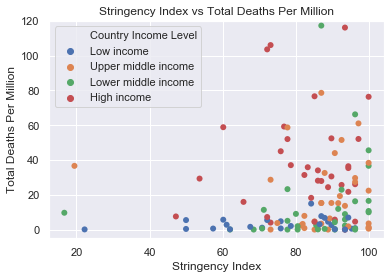

<Figure size 1800x1800 with 0 Axes>

In [16]:
sns.set()
sns.scatterplot(data = combined_stg_df, x = "Stringency Index", y = "Total Deaths Per Million", color = "darkred",
                edgecolor = "none"
                ,alpha = 1, hue = "Country Income Level")

plt.title("Stringency Index vs Total Deaths Per Million")
plt.ylim(-5, 120)
plt.figure(figsize=(25,25))
plt.show()

In [17]:
#USA
usa = strigency_per_country[(strigency_per_country["Country"]== "United States") & (strigency_per_country["Date"] < '2020-06-15')]
usa.head()

Country        Date  Total Cases  Total Cases Per Million  \
24098  United States  2019-12-31          0.0                      0.0   
24099  United States  2020-01-01          0.0                      0.0   
24100  United States  2020-01-02          0.0                      0.0   
24101  United States  2020-01-03          0.0                      0.0   
24102  United States  2020-01-04          0.0                      0.0   

       New Cases  Total Deaths Per Million  Total Deaths  Stringency Index  \
24098        0.0                       0.0           0.0               0.0   
24099        0.0                       0.0           0.0               0.0   
24100        0.0                       0.0           0.0               0.0   
24101        0.0                       0.0           0.0               0.0   
24102        0.0                       0.0           0.0               0.0   

       GDP Per Capita Income Level      Continent  
24098       54225.446  High income  North America  
24099       54225.446  High income  North America  
24100       54225.446  High income  North America  
24101       54225.446  High income  North America  
24102       54225.446  High income  North America

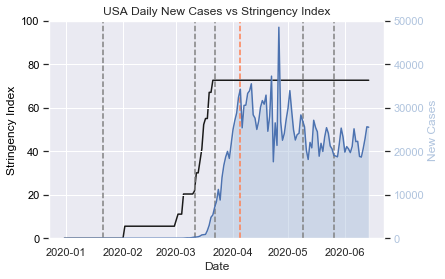

In [18]:
dates = usa["Date"].values.tolist()
usa_strigency_index=usa["Stringency Index"].values.tolist()
usa_new_cases=usa["New Cases"].values.tolist()
dates_values = [datetime.datetime.strptime(d,"%Y-%m-%d").date() for d in dates]

#Plot graph with 2 y axes
fig, ax1 = plt.subplots()

#Plot bars
ax1.plot(dates_values, usa_strigency_index, "k-")
ax1.set_xlabel('Date')

# Make the y-axis label and tick labels match the line color.
ax1.set_ylabel('Stringency Index', color='black')
[tl.set_color('black') for tl in ax1.get_yticklabels()]

#Set up ax2 to be the second y axis with x shared
ax2 = ax1.twinx()
#Plot a line
ax2.plot(dates_values, usa_new_cases, "b-")

# Make the y-axis label and tick labels match the line color.
ax2.set_ylabel("New Cases", color="lightsteelblue")
[tl.set_color("lightsteelblue") for tl in ax2.get_yticklabels()]

plt.title("USA Daily New Cases vs Stringency Index")

ax1.set_ylim([0,100])
ax2.set_ylim([0,50000])
#ax1.set_xlim(["2019-12-31", "2020-06-13"])

ax2.fill_between(dates_values,0,usa_new_cases,facecolor='lightsteelblue', alpha = 0.5)

# Plot horiontal lines
dates_important=["2020-03-11", "2020-01-21", "2020-03-22", "2020-04-05","2020-05-26", "2020-05-09", "2020-03-20"]
dates_important_values=[datetime.datetime.strptime(d,"%Y-%m-%d").date() for d in dates_important]

plt.vlines(dates_important_values[0], 0, 50000, colors='grey', linestyles='dashed', label='line1') #who declares covid a pandemic 
plt.vlines(dates_important_values[1], 0, 50000, colors='grey', linestyles='dashed', label='line1') #first US case confirmed
plt.vlines(dates_important_values[2], 0, 50000, colors='grey', linestyles='dashed', label='line1') #highest stringency index
plt.vlines(dates_important_values[3], 0, 50000, colors='coral', linestyles='dashed', label='line1') #two weeks after
plt.vlines(dates_important_values[4], 0, 50000, colors='grey', linestyles='dashed', label='line1') #floyd protest
plt.vlines(dates_important_values[5], 0, 50000, colors='grey', linestyles='dashed', label='line1') #mother's day
#plt.vlines(dates_important_values[5], 0, 50000, colors='grey', linestyles='dashed', label='line1') first day of spring

plt.savefig("../Images/USA_linechart.png")
plt.show()

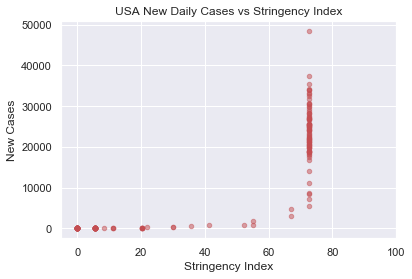

In [19]:
usa.plot(kind="scatter",y = "New Cases", x = "Stringency Index", c="r", alpha=0.5)
#plt.ylim(-70, 4000)
plt.title("USA New Daily Cases vs Stringency Index")
plt.xlim(-5, 100)
plt.savefig("../Images/USA_scatterplot.png")
plt.show()

In [20]:
#Germany
germany = strigency_per_country[(strigency_per_country["Country"]== "Germany") & (strigency_per_country["Date"] < "2020-06-14") ]

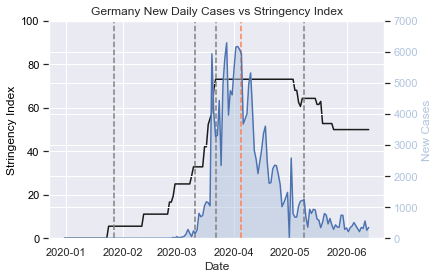

In [21]:
dates = germany["Date"].values.tolist()
usa_strigency_index=germany["Stringency Index"].values.tolist()
usa_new_cases=germany["New Cases"].values.tolist()
dates_values = [datetime.datetime.strptime(d,"%Y-%m-%d").date() for d in dates]

#Plot graph with 2 y axes
fig, ax1 = plt.subplots()

#Plot bars
ax1.plot(dates_values, usa_strigency_index, "k-")
ax1.set_xlabel('Date')

# Make the y-axis label and tick labels match the line color.
ax1.set_ylabel('Stringency Index', color='black')
[tl.set_color('black') for tl in ax1.get_yticklabels()]

#Set up ax2 to be the second y axis with x shared
ax2 = ax1.twinx()
#Plot a line
ax2.plot(dates_values, usa_new_cases, "b-")


# Make the y-axis label and tick labels match the line color.
ax2.set_ylabel("New Cases", color="lightsteelblue")
[tl.set_color("lightsteelblue") for tl in ax2.get_yticklabels()]

plt.title("Germany New Daily Cases vs Stringency Index")


ax1.set_ylim([0,100])
ax2.set_ylim([0,7000])
#ax1.set_xlim(["2019-12-31", "2020-06-13"])

ax2.fill_between(dates_values,0,usa_new_cases,facecolor='lightsteelblue', alpha = 0.5)

dates_important=["2020-03-11","2020-01-27", "2020-03-22", "2020-04-05", "2020-05-09" ]
dates_important_values=[datetime.datetime.strptime(d,"%Y-%m-%d").date() for d in dates_important]

plt.vlines(dates_important_values[0], 0, 50000, colors='grey', linestyles='dashed', label='line1') #who declares covid a pandemic 
plt.vlines(dates_important_values[1], 0, 50000, colors='grey', linestyles='dashed', label='line1') #Germany registers its first case
plt.vlines(dates_important_values[2], 0, 50000, colors='grey', linestyles='dashed', label='line1') #The government tightens its lockdown
plt.vlines(dates_important_values[3], 0, 50000, colors='coral', linestyles='dashed', label='line1') #Two weeks after lockdown
plt.vlines(dates_important_values[4], 0, 50000, colors='grey', linestyles='dashed', label='line1') #Mother's Day

plt.savefig("../Images/Germany_linechart.png")

plt.show()

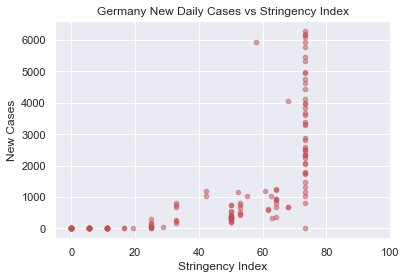

In [22]:
germany.plot(kind="scatter",y = "New Cases", x = "Stringency Index", c="r", alpha=0.5)
#plt.ylim(-70, 4000)
plt.title("Germany New Daily Cases vs Stringency Index")
plt.xlim(-5,100)
plt.savefig("../Images/Germany_scatterplot.png")
plt.show()


In [23]:
sweden = strigency_per_country[(strigency_per_country["Country"]== "Sweden")&(strigency_per_country["Date"] < "2020-06-08")]

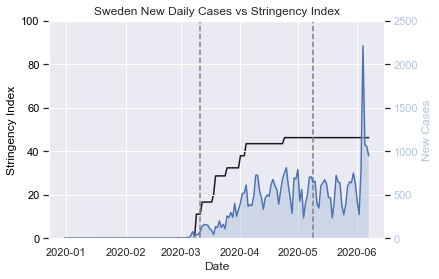

In [24]:
dates = sweden["Date"].values.tolist()
usa_strigency_index=sweden["Stringency Index"].values.tolist()
usa_new_cases=sweden["New Cases"].values.tolist()
dates_values = [datetime.datetime.strptime(d,"%Y-%m-%d").date() for d in dates]

#Plot graph with 2 y axes
fig, ax1 = plt.subplots()

#Plot bars
ax1.plot(dates_values, usa_strigency_index, "k-")
ax1.set_xlabel('Date')

# Make the y-axis label and tick labels match the line color.
ax1.set_ylabel('Stringency Index', color='black')
[tl.set_color('black') for tl in ax1.get_yticklabels()]

#Set up ax2 to be the second y axis with x shared
ax2 = ax1.twinx()
#Plot a line
ax2.plot(dates_values, usa_new_cases, "b-")


# Make the y-axis label and tick labels match the line color.
ax2.set_ylabel("New Cases", color="lightsteelblue")
[tl.set_color("lightsteelblue") for tl in ax2.get_yticklabels()]

plt.title("Sweden New Daily Cases vs Stringency Index")


ax1.set_ylim([0,100])
ax2.set_ylim([0,2500])

ax2.fill_between(dates_values,0,usa_new_cases,facecolor='lightsteelblue', alpha = 0.5)

dates_important=["2020-03-11", "2020-05-09"]
dates_important_values=[datetime.datetime.strptime(d,"%Y-%m-%d").date() for d in dates_important]

plt.vlines(dates_important_values[0], 0, 50000, colors='grey', linestyles='dashed', label='line1') #who declares covid a pandemia
plt.vlines(dates_important_values[1], 0, 50000, colors='grey', linestyles='dashed', label='line1') #mother's day

plt.savefig("../Images/Sweden_linechart.png")

plt.show()

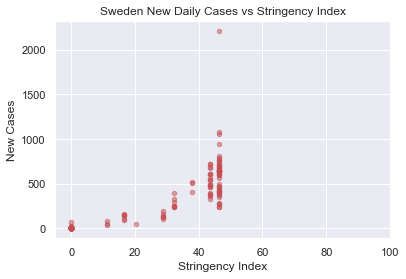

In [25]:
sweden.plot(kind="scatter",y = "New Cases", x = "Stringency Index", c="r", alpha=0.5)
#plt.ylim(-70, 4000)
plt.title("Sweden New Daily Cases vs Stringency Index")
plt.xlim(-5,100)
plt.savefig("../Images/Sweden_scatterplot.png")
plt.show()



In [26]:
canada = strigency_per_country[(strigency_per_country["Country"]== "Canada")&(strigency_per_country["Date"] < "2020-06-12")]

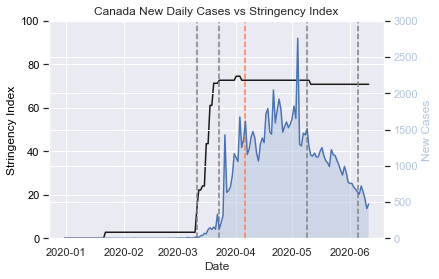

In [27]:
dates = canada["Date"].values.tolist()
usa_strigency_index=canada["Stringency Index"].values.tolist()
usa_new_cases=canada["New Cases"].values.tolist()
dates_values = [datetime.datetime.strptime(d,"%Y-%m-%d").date() for d in dates]

#Plot graph with 2 y axes
fig, ax1 = plt.subplots()

#Plot bars
ax1.plot(dates_values, usa_strigency_index, "k-")
ax1.set_xlabel('Date')

# Make the y-axis label and tick labels match the line color.
ax1.set_ylabel('Stringency Index', color='black')
[tl.set_color('black') for tl in ax1.get_yticklabels()]

#Set up ax2 to be the second y axis with x shared
ax2 = ax1.twinx()
#Plot a line
ax2.plot(dates_values, usa_new_cases, "b-")


# Make the y-axis label and tick labels match the line color.
ax2.set_ylabel("New Cases", color="lightsteelblue")
[tl.set_color("lightsteelblue") for tl in ax2.get_yticklabels()]

plt.title("Canada New Daily Cases vs Stringency Index")

ax1.set_ylim([0,100])
ax2.set_ylim([0,3000])

ax2.fill_between(dates_values,0,usa_new_cases,facecolor='lightsteelblue', alpha = 0.5)

dates_important=["2020-03-11", "2020-03-23", "2020-04-06", "2020-05-09", "2020-06-05"]
dates_important_values=[datetime.datetime.strptime(d,"%Y-%m-%d").date() for d in dates_important]

plt.vlines(dates_important_values[0], 0, 50000, colors='grey', linestyles='dashed', label='line1') #who
plt.vlines(dates_important_values[1], 0, 50000, colors='grey', linestyles='dashed', label='line1') #high stringency index
plt.vlines(dates_important_values[2], 0, 50000, colors='coral', linestyles='dashed', label='line1') #two weeks after
plt.vlines(dates_important_values[3], 0, 50000, colors='grey', linestyles='dashed', label='line1') #mother's day
plt.vlines(dates_important_values[4], 0, 50000, colors='grey', linestyles='dashed', label='line1') #blm


plt.savefig("../Images/Canada_linechart.png")

plt.show()

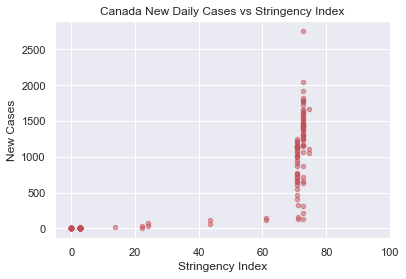

In [28]:
canada.plot(kind="scatter",y = "New Cases", x = "Stringency Index", c="r", alpha=0.5)
#plt.ylim(-70, 4000)
plt.title("Canada New Daily Cases vs Stringency Index")
plt.xlim(-5,100)
plt.savefig("../Images/Caanada_scatterplot.png")
plt.show()

In [29]:
peru = strigency_per_country[(strigency_per_country["Country"]== "Peru")&(strigency_per_country["Date"] < "2020-06-21")]

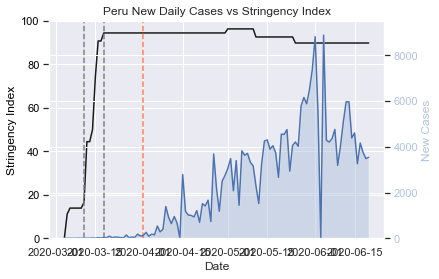

In [30]:
dates = peru["Date"].values.tolist()
usa_strigency_index=peru["Stringency Index"].values.tolist()
usa_new_cases=peru["New Cases"].values.tolist()
dates_values = [datetime.datetime.strptime(d,"%Y-%m-%d").date() for d in dates]

#Plot graph with 2 y axes
fig, ax1 = plt.subplots()

#Plot bars
ax1.plot(dates_values, usa_strigency_index, "k-")
ax1.set_xlabel('Date')

# Make the y-axis label and tick labels match the line color.
ax1.set_ylabel('Stringency Index', color='black')
[tl.set_color('black') for tl in ax1.get_yticklabels()]

#Set up ax2 to be the second y axis with x shared
ax2 = ax1.twinx()
#Plot a line
ax2.plot(dates_values, usa_new_cases, "b-")


# Make the y-axis label and tick labels match the line color.
ax2.set_ylabel("New Cases", color="lightsteelblue")
[tl.set_color("lightsteelblue") for tl in ax2.get_yticklabels()]

plt.title("Peru New Daily Cases vs Stringency Index")

ax1.set_ylim([0,100])
ax2.set_ylim([0,9500])

ax2.fill_between(dates_values,0,usa_new_cases,facecolor='lightsteelblue', alpha = 0.5)

dates_important=["2020-03-11", "2020-03-18", "2020-04-01"]
dates_important_values=[datetime.datetime.strptime(d,"%Y-%m-%d").date() for d in dates_important]

plt.vlines(dates_important_values[0], 0, 50000, colors='grey', linestyles='dashed', label='line1')
plt.vlines(dates_important_values[1], 0, 50000, colors='grey', linestyles='dashed', label='line1')
plt.vlines(dates_important_values[2], 0, 50000, colors='coral', linestyles='dashed', label='line1')

plt.savefig("../Images/Peru_linechart.png")

plt.show()


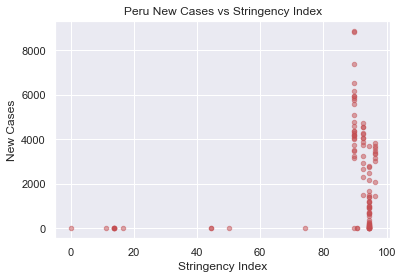

In [31]:
peru.plot(kind="scatter",y = "New Cases", x = "Stringency Index", c="r", alpha=0.5)
#plt.ylim(-70, 4000)
plt.title("Peru New Cases vs Stringency Index")
plt.xlim()
plt.savefig("../Images/Peru_scatterplot.png")
plt.show()

In [32]:
italy = strigency_per_country[(strigency_per_country["Country"]== "Italy")&(strigency_per_country["Date"] < "2020-06-12")]

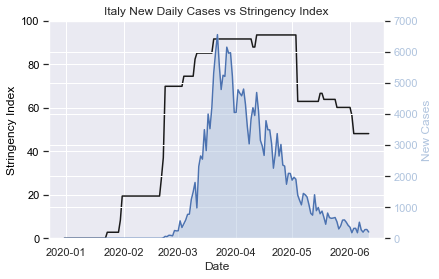

In [33]:
dates = italy["Date"].values.tolist()
usa_strigency_index=italy["Stringency Index"].values.tolist()
usa_new_cases=italy["New Cases"].values.tolist()
dates_values = [datetime.datetime.strptime(d,"%Y-%m-%d").date() for d in dates]

#Plot graph with 2 y axes
fig, ax1 = plt.subplots()

#Plot bars
ax1.plot(dates_values, usa_strigency_index, "k-")
ax1.set_xlabel('Date')

# Make the y-axis label and tick labels match the line color.
ax1.set_ylabel('Stringency Index', color='black')
[tl.set_color('black') for tl in ax1.get_yticklabels()]

#Set up ax2 to be the second y axis with x shared
ax2 = ax1.twinx()
#Plot a line
ax2.plot(dates_values, usa_new_cases, "b-")


# Make the y-axis label and tick labels match the line color.
ax2.set_ylabel("New Cases", color="lightsteelblue")
[tl.set_color("lightsteelblue") for tl in ax2.get_yticklabels()]

plt.title("Italy New Daily Cases vs Stringency Index")


ax1.set_ylim([0,100])
ax2.set_ylim([0,7000])
#ax1.set_xlim(["2019-12-31", "2020-06-13"])

ax2.fill_between(dates_values,0,usa_new_cases,facecolor='lightsteelblue', alpha = 0.5)

#dates_important=["2020-03-21", "2020-05-09"]
#dates_important_values=[datetime.datetime.strptime(d,"%Y-%m-%d").date() for d in dates_important]

#plt.vlines(dates_important_values[0], 0, 50000, colors='grey', linestyles='dashed', label='line1')
#plt.vlines(dates_important_values[1], 0, 50000, colors='grey', linestyles='dashed', label='line1')

plt.savefig("../Images/Italy_linechart.png")

plt.show()


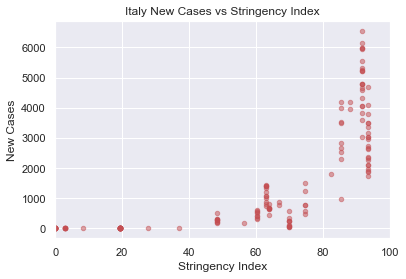

In [34]:
italy.plot(kind="scatter",y = "New Cases", x = "Stringency Index", c="r", alpha=0.5)
#plt.ylim(-70, 4000)
plt.title("Italy New Cases vs Stringency Index")
plt.xlim(0,100)
plt.savefig("../Images/Italy_scatterplot.png")
plt.show()

In [35]:
new_zealand = strigency_per_country[(strigency_per_country["Country"]== "New Zealand")&(strigency_per_country["Date"] < "2020-06-19")]



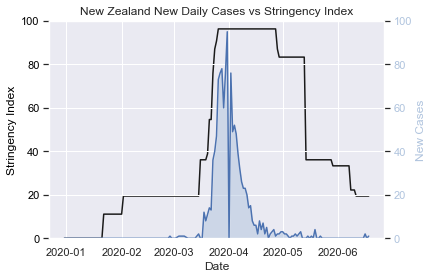

In [36]:
dates = new_zealand["Date"].values.tolist()
usa_strigency_index=new_zealand["Stringency Index"].values.tolist()
usa_new_cases=new_zealand["New Cases"].values.tolist()
dates_values = [datetime.datetime.strptime(d,"%Y-%m-%d").date() for d in dates]

#Plot graph with 2 y axes
fig, ax1 = plt.subplots()

#Plot bars
ax1.plot(dates_values, usa_strigency_index, "k-")
ax1.set_xlabel('Date')

# Make the y-axis label and tick labels match the line color.
ax1.set_ylabel('Stringency Index', color='black')
[tl.set_color('black') for tl in ax1.get_yticklabels()]

#Set up ax2 to be the second y axis with x shared
ax2 = ax1.twinx()
#Plot a line
ax2.plot(dates_values, usa_new_cases, "b-")


# Make the y-axis label and tick labels match the line color.
ax2.set_ylabel("New Cases", color="lightsteelblue")
[tl.set_color("lightsteelblue") for tl in ax2.get_yticklabels()]

plt.title("New Zealand New Daily Cases vs Stringency Index")


ax1.set_ylim([0,100])
ax2.set_ylim([0,100])
#ax1.set_xlim(["2019-12-31", "2020-06-13"])

ax2.fill_between(dates_values,0,usa_new_cases,facecolor='lightsteelblue', alpha = 0.5)

#dates_important=["2020-03-21", "2020-05-09"]
#dates_important_values=[datetime.datetime.strptime(d,"%Y-%m-%d").date() for d in dates_important]

#plt.vlines(dates_important_values[0], 0, 50000, colors='grey', linestyles='dashed', label='line1')
#plt.vlines(dates_important_values[1], 0, 50000, colors='grey', linestyles='dashed', label='line1')

plt.savefig("../Images/New_zealand_linechart.png")

plt.show()

In [37]:
chile = strigency_per_country[(strigency_per_country["Country"]== "Chile")&(strigency_per_country["Date"] < "2020-06-11")]

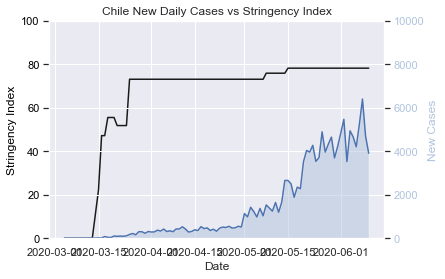

In [38]:
dates = chile["Date"].values.tolist()
usa_strigency_index=chile["Stringency Index"].values.tolist()
usa_new_cases=chile["New Cases"].values.tolist()
dates_values = [datetime.datetime.strptime(d,"%Y-%m-%d").date() for d in dates]

#Plot graph with 2 y axes
fig, ax1 = plt.subplots()

#Plot bars
ax1.plot(dates_values, usa_strigency_index, "k-")
ax1.set_xlabel('Date')

# Make the y-axis label and tick labels match the line color.
ax1.set_ylabel('Stringency Index', color='black')
[tl.set_color('black') for tl in ax1.get_yticklabels()]

#Set up ax2 to be the second y axis with x shared
ax2 = ax1.twinx()
#Plot a line
ax2.plot(dates_values, usa_new_cases, "b-")


# Make the y-axis label and tick labels match the line color.
ax2.set_ylabel("New Cases", color="lightsteelblue")
[tl.set_color("lightsteelblue") for tl in ax2.get_yticklabels()]

plt.title("Chile New Daily Cases vs Stringency Index")


ax1.set_ylim([0,100])
ax2.set_ylim([0,10000])
#ax1.set_xlim(["2019-12-31", "2020-06-13"])

ax2.fill_between(dates_values,0,usa_new_cases,facecolor='lightsteelblue', alpha = 0.5)

#dates_important=["2020-03-21", "2020-05-09"]
#dates_important_values=[datetime.datetime.strptime(d,"%Y-%m-%d").date() for d in dates_important]

#plt.vlines(dates_important_values[0], 0, 50000, colors='grey', linestyles='dashed', label='line1')
#plt.vlines(dates_important_values[1], 0, 50000, colors='grey', linestyles='dashed', label='line1')

plt.savefig("../Images/Chile_linechart.png")

plt.show()

In [39]:
# Braden's branch starts from here

In [40]:
# delete the data for "2020-06-22" because it is not complete
combined_df=combined_df[combined_df['Date']!="2020-06-22"]

combined_df.head()

Continent      Country        Date  Total Cases  New Cases  Total Deaths  \
0      Asia  Afghanistan  2019-12-31          0.0        0.0           0.0   
1      Asia  Afghanistan  2020-01-01          0.0        0.0           0.0   
2      Asia  Afghanistan  2020-01-02          0.0        0.0           0.0   
3      Asia  Afghanistan  2020-01-03          0.0        0.0           0.0   
4      Asia  Afghanistan  2020-01-04          0.0        0.0           0.0   

   Total Cases Per Million  Total Deaths Per Million  \
0                      0.0                       0.0   
1                      0.0                       0.0   
2                      0.0                       0.0   
3                      0.0                       0.0   
4                      0.0                       0.0   

   Total Test Per Thousands  Stringency Index  ...  Aged 65 or older  \
0                       NaN               NaN  ...             2.581   
1                       NaN               0.0  ...             2.581   
2                       NaN               0.0  ...             2.581   
3                       NaN               0.0  ...             2.581   
4                       NaN               0.0  ...             2.581   

   GDP Per Capita  Covid Death Rate  diabetes_prevalence  \
0        1803.987           597.029                 9.59   
1        1803.987           597.029                 9.59   
2        1803.987           597.029                 9.59   
3        1803.987           597.029                 9.59   
4        1803.987           597.029                 9.59   

   Hospital Beds (per 10K people)  Smoking Percetage School Status Latitude  \
0                             5.0                NaN        Closed   34.023   
1                             5.0                NaN        Closed   34.023   
2                             5.0                NaN        Closed   34.023   
3                             5.0                NaN        Closed   34.023   
4                             5.0                NaN        Closed   34.023   

   Longitude  Income Level  
0    65.5267    Low income  
1    65.5267    Low income  
2    65.5267    Low income  
3    65.5267    Low income  
4    65.5267    Low income  

[5 rows x 21 columns]

In [41]:
# get the daily case data for the world
world_data = combined_df[combined_df['Country']=='World']
world_cases=world_data['Total Cases'].values.tolist()

# get the daily case data for Africa
africa_cases = combined_df[(combined_df['Continent']=='Africa')].groupby("Date")
africa_cases_daily = africa_cases.sum()
africa_cases_list= africa_cases_daily['Total Cases'].values.tolist()

# get the daily case data for Asia
asia_cases = combined_df[(combined_df['Continent']=='Asia')].groupby("Date")
asia_cases_daily = asia_cases.sum()
asia_cases_list= asia_cases_daily['Total Cases'].values.tolist()

# get the daily case data for Europe
europe_cases = combined_df[(combined_df['Continent']=='Europe')].groupby("Date")
europe_cases_daily = europe_cases.sum()
europe_cases_list= europe_cases_daily['Total Cases'].values.tolist()

# get the daily case data for North America
north_america_cases = combined_df[(combined_df['Continent']=='North America')].groupby("Date")
north_america_cases_daily = north_america_cases.sum()
north_america_cases_list= north_america_cases_daily['Total Cases'].values.tolist()

# get the daily case data for Oceania
oceania_cases = combined_df[(combined_df['Continent']=='Oceania')].groupby("Date")
oceania_cases_daily = oceania_cases.sum()
oceania_cases_list= oceania_cases_daily['Total Cases'].values.tolist()

# get the daily case data for South America
south_america_cases = combined_df[(combined_df['Continent']=='South America')].groupby("Date")
south_america_cases_daily = south_america_cases.sum()
south_america_cases_list= south_america_cases_daily['Total Cases'].values.tolist()

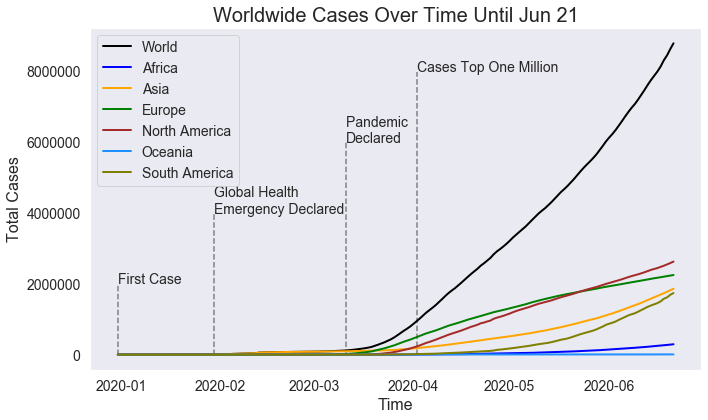

In [42]:
# change the dates to time series
dates = world_data['Date'].values.tolist()
dates_values = [datetime.datetime.strptime(d,"%Y-%m-%d").date() for d in dates]

# plot of cases over time 
plt.figure(figsize=(10,6))

world_handle, = plt.plot(dates_values, world_cases,color="black",label="World",linewidth=2)
africa_handle, = plt.plot(dates_values, africa_cases_list,color="blue",label="Africa",linewidth=2)
asia_handle, = plt.plot(dates_values, asia_cases_list,color="orange",label="Asia",linewidth=2)
europe_handle, = plt.plot(dates_values, europe_cases_list,color="green",label="Europe",linewidth=2)
north_america_handle, = plt.plot(dates_values, north_america_cases_list,color="brown",label="North America",linewidth=2)
oceania_handle, = plt.plot(dates_values, oceania_cases_list,color="dodgerblue",label="Oceania",linewidth=2)
south_america_handle, = plt.plot(dates_values, south_america_cases_list,color="olive",label="South America",linewidth=2)

plt.legend(loc="upper left", fontsize=14)
plt.title("Worldwide Cases Over Time Until Jun 21", fontsize=20)

plt.tick_params(axis='both', which='major', labelsize=14)
plt.xlabel("Time",fontsize=16)
plt.ylabel("Total Cases", fontsize=16)

# mark important dates in the plot
dates_important=["2019-12-31", "2020-01-30", "2020-03-11", "2020-04-02"]
dates_important_values=[datetime.datetime.strptime(d,"%Y-%m-%d").date() for d in dates_important]

plt.vlines(dates_important_values[0], 0, 2000000, colors='grey', linestyles='dashed', label='line1') #who declares covid a pandemic 
plt.vlines(dates_important_values[1], 0, 4000000, colors='grey', linestyles='dashed', label='line1') #first US case confirmed
plt.vlines(dates_important_values[2], 0, 6000000, colors='grey', linestyles='dashed', label='line1')
plt.vlines(dates_important_values[3], 0, 8000000, colors='grey', linestyles='dashed', label='line1')

plt.text(dates_important_values[0], 2000000,"First Case", size=14)
plt.text(dates_important_values[1], 4000000,"Global Health \nEmergency Declared", size=14)
plt.text(dates_important_values[2], 6000000,"Pandemic \nDeclared", size=14)
plt.text(dates_important_values[3], 8000000,"Cases Top One Million", size=14)

plt.tight_layout()
plt.grid()
plt.savefig('Worldwide Cases1.png', dpi=400)
plt.show()


In [43]:
# cases in different countries on Jun 21, 2020
countries_data = combined_df[(combined_df['Date']=='2020-06-21') & (combined_df['Country']!='World')]
# store country names into a list
countries_list = countries_data['Country'].values.tolist()

countries_data.head()

Continent      Country        Date  Total Cases  New Cases  Total Deaths  \
163      Asia  Afghanistan  2020-06-21      28424.0      546.0         569.0   
269    Europe      Albania  2020-06-21       1891.0       53.0          43.0   
439    Africa      Algeria  2020-06-21      11631.0      127.0         837.0   
540    Europe      Andorra  2020-06-21        855.0        0.0          52.0   
633    Africa       Angola  2020-06-21        172.0        6.0           8.0   

     Total Cases Per Million  Total Deaths Per Million  \
163                  730.162                    14.617   
269                  657.099                    14.942   
439                  265.239                    19.087   
540                11065.812                   673.008   
633                    5.233                     0.243   

     Total Test Per Thousands  Stringency Index  ...  Aged 65 or older  \
163                       NaN               NaN  ...             2.581   
269                       NaN               NaN  ...            13.188   
439                       NaN               NaN  ...             6.211   
540                       NaN               NaN  ...               NaN   
633                       NaN               NaN  ...             2.405   

     GDP Per Capita  Covid Death Rate  diabetes_prevalence  \
163        1803.987           597.029                 9.59   
269       11803.431           304.195                10.08   
439       13913.839           278.364                 6.73   
540             NaN           109.135                 7.97   
633        5819.495           276.045                 3.94   

     Hospital Beds (per 10K people)  Smoking Percetage          School Status  \
163                             5.0                NaN                 Closed   
269                            29.0             11.20   Open with limitations   
439                            19.0             15.20                  Closed   
540                             NaN             21.40                     NaN   
633                             8.0                NaN                 Closed   

    Latitude  Longitude         Income Level  
163  34.0230    65.5267           Low income  
269  40.6540    20.0760  Upper middle income  
439  28.6045     2.6400  Upper middle income  
540      NaN        NaN                  NaN  
633 -12.8360    17.8080  Lower middle income  

[5 rows x 21 columns]

In [44]:
countries_data=countries_data.set_index('Country')
countries_data.head()

Continent        Date  Total Cases  New Cases  Total Deaths  \
Country                                                                   
Afghanistan      Asia  2020-06-21      28424.0      546.0         569.0   
Albania        Europe  2020-06-21       1891.0       53.0          43.0   
Algeria        Africa  2020-06-21      11631.0      127.0         837.0   
Andorra        Europe  2020-06-21        855.0        0.0          52.0   
Angola         Africa  2020-06-21        172.0        6.0           8.0   

             Total Cases Per Million  Total Deaths Per Million  \
Country                                                          
Afghanistan                  730.162                    14.617   
Albania                      657.099                    14.942   
Algeria                      265.239                    19.087   
Andorra                    11065.812                   673.008   
Angola                         5.233                     0.243   

             Total Test Per Thousands  Stringency Index  Population Density  \
Country                                                                       
Afghanistan                       NaN               NaN              54.422   
Albania                           NaN               NaN             104.871   
Algeria                           NaN               NaN              17.348   
Andorra                           NaN               NaN             163.755   
Angola                            NaN               NaN              23.890   

             Aged 65 or older  GDP Per Capita  Covid Death Rate  \
Country                                                           
Afghanistan             2.581        1803.987           597.029   
Albania                13.188       11803.431           304.195   
Algeria                 6.211       13913.839           278.364   
Andorra                   NaN             NaN           109.135   
Angola                  2.405        5819.495           276.045   

             diabetes_prevalence  Hospital Beds (per 10K people)  \
Country                                                            
Afghanistan                 9.59                             5.0   
Albania                    10.08                            29.0   
Algeria                     6.73                            19.0   
Andorra                     7.97                             NaN   
Angola                      3.94                             8.0   

            Smoking Percetage          School Status  Latitude  Longitude  \
Country                                                                     
Afghanistan               NaN                 Closed   34.0230    65.5267   
Albania                11.20   Open with limitations   40.6540    20.0760   
Algeria                15.20                  Closed   28.6045     2.6400   
Andorra                21.40                     NaN       NaN        NaN   
Angola                    NaN                 Closed  -12.8360    17.8080   

                    Income Level  
Country                           
Afghanistan           Low income  
Albania      Upper middle income  
Algeria      Upper middle income  
Andorra                      NaN  
Angola       Lower middle income

# Use google API to find the lattitude and longitude for different countires, then save them into lists
# currently markdown, change to code when you want to check the heatmap
from config import gkey
lat_list=[]
lng_list=[]
country_update=[]
country_case_list=[]

for country in countries_list:
    
    params = {"address": country, "key": gkey}
    base_url = "https://maps.googleapis.com/maps/api/geocode/json"
    response = requests.get(base_url, params=params)
    country_geo = response.json()
    country_case = countries_data.loc[country, "Total Cases"]

    try:
        lat = country_geo["results"][0]["geometry"]["location"]["lat"]
        lng = country_geo["results"][0]["geometry"]["location"]["lng"]
        
        lat_list.append(lat)
        lng_list.append(lng)
        country_update.append(country)
        country_case_list.append(country_case)
        
        
    except:
        print("Country not found")
        pass

# google heatmap for cases on Jun 21
# currently markdown, change to code when you want to check the heatmap
gmaps.configure(api_key=gkey)
cases_map_df = pd.DataFrame({'Country':country_update,'Lat':lat_list, 'Lng':lng_list,"Case Number":country_case_list})
locations = cases_map_df[["Lat", "Lng"]].astype(float)
cases = cases_map_df['Case Number'].astype(float)

fig = gmaps.Map()

heat_layer = gmaps.heatmap_layer(locations, weights=cases, 
                                 dissipating=False, max_intensity=300000,
                                 point_radius =6)

fig.add_layer(heat_layer)

fig

In [45]:
# countries data with number index
countries_data_number_index=countries_data.reset_index()
countries_data_number_index.head()

Country Continent        Date  Total Cases  New Cases  Total Deaths  \
0  Afghanistan      Asia  2020-06-21      28424.0      546.0         569.0   
1      Albania    Europe  2020-06-21       1891.0       53.0          43.0   
2      Algeria    Africa  2020-06-21      11631.0      127.0         837.0   
3      Andorra    Europe  2020-06-21        855.0        0.0          52.0   
4       Angola    Africa  2020-06-21        172.0        6.0           8.0   

   Total Cases Per Million  Total Deaths Per Million  \
0                  730.162                    14.617   
1                  657.099                    14.942   
2                  265.239                    19.087   
3                11065.812                   673.008   
4                    5.233                     0.243   

   Total Test Per Thousands  Stringency Index  ...  Aged 65 or older  \
0                       NaN               NaN  ...             2.581   
1                       NaN               NaN  ...            13.188   
2                       NaN               NaN  ...             6.211   
3                       NaN               NaN  ...               NaN   
4                       NaN               NaN  ...             2.405   

   GDP Per Capita  Covid Death Rate  diabetes_prevalence  \
0        1803.987           597.029                 9.59   
1       11803.431           304.195                10.08   
2       13913.839           278.364                 6.73   
3             NaN           109.135                 7.97   
4        5819.495           276.045                 3.94   

   Hospital Beds (per 10K people)  Smoking Percetage          School Status  \
0                             5.0                NaN                 Closed   
1                            29.0             11.20   Open with limitations   
2                            19.0             15.20                  Closed   
3                             NaN             21.40                     NaN   
4                             8.0                NaN                 Closed   

  Latitude  Longitude         Income Level  
0  34.0230    65.5267           Low income  
1  40.6540    20.0760  Upper middle income  
2  28.6045     2.6400  Upper middle income  
3      NaN        NaN                  NaN  
4 -12.8360    17.8080  Lower middle income  

[5 rows x 21 columns]

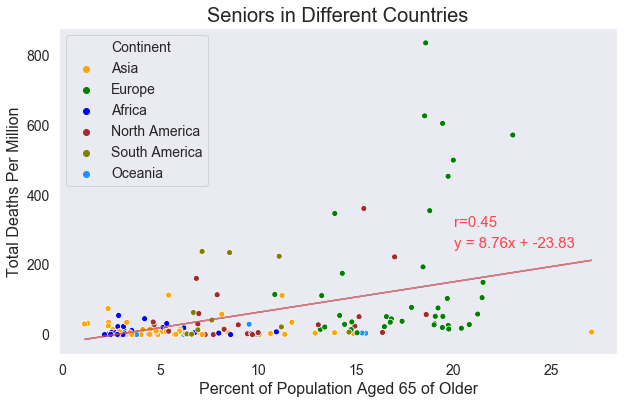

In [46]:
# scatter plot of people aged 65 or older vs. death per million worldwide
plt.figure(figsize=(10,6))

# linear regression and correlation
age_death=countries_data_number_index[["Aged 65 or older","Total Deaths Per Million",'Continent']]
age_death_updated=age_death.dropna()
x_values=age_death_updated["Aged 65 or older"]
y_values=age_death_updated["Total Deaths Per Million"]
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
correlation = st.pearsonr(x_values,y_values)
correlation_eq="r="+str(round(correlation[0],2))

color_dict = dict({'Asia':'Orange',
                  'Europe':'green',
                  'Africa': 'blue',
                  'North America': 'brown',
                   'South America': 'olive',
                  'Oceania':'dodgerblue'})
sns.scatterplot(x="Aged 65 or older",y="Total Deaths Per Million", 
              hue="Continent",palette=color_dict, 
              data=age_death_updated)
plt.plot(x_values,regress_values,"r-",alpha=0.7)

plt.title("Seniors in Different Countries",fontsize=20)

plt.annotate(line_eq,(20,250),fontsize=15,color="red",alpha=0.7)
plt.annotate(correlation_eq,(20,310),fontsize=15,color="red",alpha=0.7)

plt.legend(loc="upper left", fontsize=14)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.xlabel("Percent of Population Aged 65 of Older",fontsize=16)
plt.ylabel("Total Deaths Per Million", fontsize=16)
plt.grid()
plt.savefig('Seniors in Different Countries.png', dpi=400)
plt.show()

In [47]:
# derive data for different continents
africa_65_cases_df=countries_data_number_index[countries_data_number_index['Continent']=="Africa"]
asia_65_cases_df=countries_data_number_index[countries_data_number_index['Continent']=="Asia"]
europe_65_cases_df=countries_data_number_index[countries_data_number_index['Continent']=="Europe"]
north_america_65_cases_df=countries_data_number_index[countries_data_number_index['Continent']=="North America"]
oceania_65_cases_df=countries_data_number_index[countries_data_number_index['Continent']=="Oceania"]
south_america_65_cases_df=countries_data_number_index[countries_data_number_index['Continent']=="South America"]

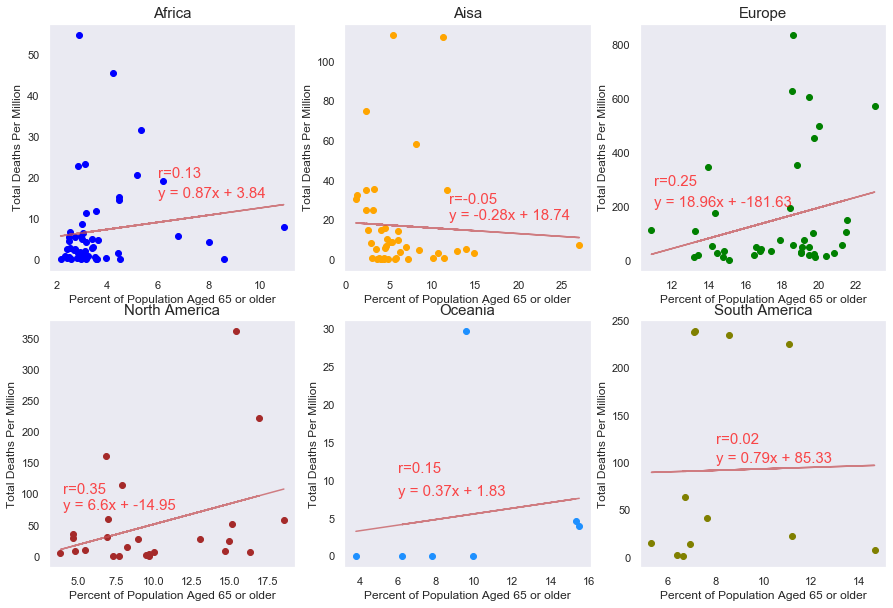

In [48]:
# scatter plot of people aged 65 or older vs. death per million break down by continents

fig, axs = plt.subplots(2,3,figsize=(15,10))

# africa
africa_65_cases_df_updated=africa_65_cases_df[["Aged 65 or older","Total Deaths Per Million"]]
africa_65_cases_df_updated=africa_65_cases_df_updated.dropna()
x_values=africa_65_cases_df_updated["Aged 65 or older"]
y_values=africa_65_cases_df_updated["Total Deaths Per Million"]
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
axs[0,0].scatter(x_values, y_values,color='blue')
axs[0,0].plot(x_values,regress_values,"r-",alpha=0.7)
axs[0,0].set_title('Africa', size=15) # Title
axs[0,0].set_xlabel('Percent of Population Aged 65 or older', fontsize = 12) 
axs[0,0].set_ylabel('Total Deaths Per Million', fontsize = 12) 
axs[0,0].annotate(line_eq,(6,15),fontsize=15,color="red",alpha=0.7)
correlation = st.pearsonr(x_values,y_values)
correlation_eq="r="+str(round(correlation[0],2))
axs[0,0].annotate(correlation_eq,(6,20),fontsize=15,color="red",alpha=0.7)
axs[0,0].grid()

# asia
aisa_65_cases_df_updated=asia_65_cases_df[["Aged 65 or older","Total Deaths Per Million"]]
aisa_65_cases_df_updated=aisa_65_cases_df_updated.dropna()
x_values=aisa_65_cases_df_updated["Aged 65 or older"]
y_values=aisa_65_cases_df_updated["Total Deaths Per Million"]
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
axs[0,1].scatter(x_values, y_values,color='orange')
axs[0,1].plot(x_values,regress_values,"r-",alpha=0.7)
axs[0,1].set_title('Aisa', size=15) # Title
axs[0,1].set_xlabel('Percent of Population Aged 65 or older', fontsize = 12)
axs[0,1].set_ylabel('Total Deaths Per Million', fontsize = 12) 
axs[0,1].annotate(line_eq,(12,20),fontsize=15,color="red",alpha=0.7)
correlation = st.pearsonr(x_values,y_values)
correlation_eq="r="+str(round(correlation[0],2))
axs[0,1].annotate(correlation_eq,(12,28),fontsize=15,color="red",alpha=0.7)
axs[0,1].grid()

# europe
europe_65_cases_df_updated=europe_65_cases_df[["Aged 65 or older","Total Deaths Per Million"]]
europe_65_cases_df_updated=europe_65_cases_df_updated.dropna()
x_values=europe_65_cases_df_updated["Aged 65 or older"]
y_values=europe_65_cases_df_updated["Total Deaths Per Million"]
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
axs[0,2].scatter(x_values, y_values,color='green')
axs[0,2].plot(x_values,regress_values,"r-",alpha=0.7)
axs[0,2].set_title('Europe', size=15) # Title
axs[0,2].set_xlabel('Percent of Population Aged 65 or older', fontsize = 12)
axs[0,2].set_ylabel('Total Deaths Per Million', fontsize = 12) 
axs[0,2].annotate(line_eq,(11,200),fontsize=15,color="red",alpha=0.7)
correlation = st.pearsonr(x_values,y_values)
correlation_eq="r="+str(round(correlation[0],2))
axs[0,2].annotate(correlation_eq,(11,280),fontsize=15,color="red",alpha=0.7)
axs[0,2].grid()

# North America
north_america_65_cases_df_updated=north_america_65_cases_df[["Aged 65 or older","Total Deaths Per Million"]]
north_america_65_cases_df_updated=north_america_65_cases_df_updated.dropna()
x_values=north_america_65_cases_df_updated["Aged 65 or older"]
y_values=north_america_65_cases_df_updated["Total Deaths Per Million"]
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
axs[1,0].scatter(x_values, y_values,color='brown')
axs[1,0].plot(x_values,regress_values,"r-",alpha=0.7)
axs[1,0].set_title('North America', size=15) # Title
axs[1,0].set_xlabel('Percent of Population Aged 65 or older', fontsize = 12) 
axs[1,0].set_ylabel('Total Deaths Per Million', fontsize = 12) 
axs[1,0].annotate(line_eq,(4,75),fontsize=15,color="red",alpha=0.7)
correlation = st.pearsonr(x_values,y_values)
correlation_eq="r="+str(round(correlation[0],2))
axs[1,0].annotate(correlation_eq,(4,100),fontsize=15,color="red",alpha=0.7)
axs[1,0].grid()


#oceania
oceania_65_cases_df_updated=oceania_65_cases_df[["Aged 65 or older","Total Deaths Per Million"]]
oceania_65_cases_df_updated=oceania_65_cases_df_updated.dropna()
x_values=oceania_65_cases_df_updated["Aged 65 or older"]
y_values=oceania_65_cases_df_updated["Total Deaths Per Million"]
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
axs[1,1].scatter(x_values, y_values,color='dodgerblue')
axs[1,1].plot(x_values,regress_values,"r-",alpha=0.7)
axs[1,1].set_title('Oceania', size=15) # Title
axs[1,1].set_xlabel('Percent of Population Aged 65 or older', fontsize = 12) 
axs[1,1].set_ylabel('Total Deaths Per Million', fontsize = 12) 
axs[1,1].annotate(line_eq,(6,8),fontsize=15,color="red",alpha=0.7)
correlation = st.pearsonr(x_values,y_values)
correlation_eq="r="+str(round(correlation[0],2))
axs[1,1].annotate(correlation_eq,(6,11),fontsize=15,color="red",alpha=0.7)
axs[1,1].grid()

#south america
south_america_65_cases_df_updated=south_america_65_cases_df[["Aged 65 or older","Total Deaths Per Million"]]
south_america_65_cases_df_updated=south_america_65_cases_df_updated.dropna()
x_values=south_america_65_cases_df_updated["Aged 65 or older"]
y_values=south_america_65_cases_df_updated["Total Deaths Per Million"]
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
axs[1,2].scatter(x_values, y_values,color='olive')
axs[1,2].plot(x_values,regress_values,"r-",alpha=0.7)
axs[1,2].set_title('South America', size=15) # Title
axs[1,2].set_xlabel('Percent of Population Aged 65 or older', fontsize = 12)
axs[1,2].set_ylabel('Total Deaths Per Million', fontsize = 12) 
axs[1,2].annotate(line_eq,(8,100),fontsize=15,color="red",alpha=0.7)
correlation = st.pearsonr(x_values,y_values)
correlation_eq="r="+str(round(correlation[0],2))
axs[1,2].annotate(correlation_eq,(8,120),fontsize=15,color="red",alpha=0.7)
axs[1,2].grid()

# plt.tick_params(axis='both', which='major', labelsize=14)
plt.savefig('Death rate of the elder in different continents.png', dpi=400)
plt.show()

In [49]:
# Braden's branch ends here

In [50]:
#Tim's branch starts here 

In [51]:
comb=combined_df.sort_values(by='Date', ascending=True)

In [52]:
sch_df=comb.loc[comb["Date"]=="2020-06-21"]
sch_df=sch_df.dropna(subset=['Income Level', 'School Status'])
schooltype_df=pd.DataFrame(sch_df["School Status"].value_counts())
schooltype_df=schooltype_df.reset_index()
schooltype_df=schooltype_df.rename(columns={"index": "Closure type"})
schooltype_df


Closure type  School Status
0                    Closed            111
1     Open with limitations             44
2  Closed (in select areas)              3
3                      Open              2
4  Seasonal school closures              1

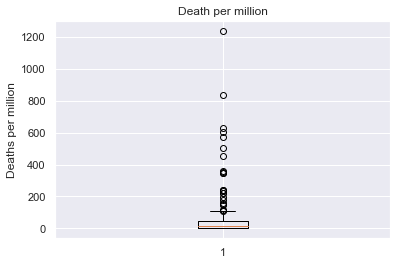

In [53]:
timest = list( sch_df['Total Deaths Per Million'])
figt, axt = plt.subplots()
axt.set_title('Death per million')
axt.set_ylabel('Deaths per million')
axt.boxplot(timest)
plt.savefig('Box Plot',dpi=400)
plt.show()

In [54]:
quartilest = sch_df['Total Deaths Per Million'].quantile([.25,.5,.75])
lowerqt = quartilest[0.25]
upperqt = quartilest[0.75]
iqrt = upperqt-lowerqt

lower_boundt = lowerqt - (1.5*iqrt)
upper_boundt = upperqt + (1.5*iqrt)

quartilestt1 = sch_df['diabetes_prevalence'].quantile([.25,.5,.75])
lowerqt1 = quartilestt1[0.25]
upperqt1 = quartilestt1[0.75]
iqrt1 = upperqt1-lowerqt1

lower_boundtt1 = lowerqt1 - (1.5*iqrt1)
upper_boundtt1 = upperqt1 + (1.5*iqrt1)



tCleaned_df = sch_df.loc[( sch_df['Total Deaths Per Million']> lower_boundt)&
                        (sch_df['Total Deaths Per Million'] < upper_boundt)& 
                        (sch_df['diabetes_prevalence'] < upper_boundtt1)&
                       (sch_df['diabetes_prevalence'] > lower_boundtt1)& 
                       (sch_df['Income Level']!="NaN")]



tCleaned_df.head()

Continent     Country        Date  Total Cases  New Cases  \
2354          Europe     Belarus  2020-06-21      57936.0      603.0   
15665         Europe  Montenegro  2020-06-21        359.0        4.0   
439           Africa     Algeria  2020-06-21      11631.0      127.0   
9521   North America     Grenada  2020-06-21         23.0        0.0   
9334          Europe      Greece  2020-06-21       3256.0       19.0   

       Total Deaths  Total Cases Per Million  Total Deaths Per Million  \
2354          343.0                 6131.234                    36.299   
15665           9.0                  571.600                    14.330   
439           837.0                  265.239                    19.087   
9521            0.0                  204.410                     0.000   
9334          190.0                  312.384                    18.229   

       Total Test Per Thousands  Stringency Index  ...  Aged 65 or older  \
2354                        NaN               NaN  ...            14.799   
15665                       NaN               NaN  ...            14.762   
439                         NaN               NaN  ...             6.211   
9521                        NaN               NaN  ...             7.304   
9334                        NaN               NaN  ...            20.396   

       GDP Per Capita  Covid Death Rate  diabetes_prevalence  \
2354        17167.967           443.129                 5.18   
15665       16409.288           387.305                10.08   
439         13913.839           278.364                 6.73   
9521        13593.877           243.964                10.71   
9334        24574.382           175.695                 4.55   

       Hospital Beds (per 10K people)  Smoking Percetage  \
2354                            110.0             20.70    
15665                            40.0                NaN   
439                              19.0             15.20    
9521                             37.0                NaN   
9334                             43.0                NaN   

               School Status Latitude  Longitude         Income Level  
2354   Open with limitations  53.3292    27.9492  Upper middle income  
15665                 Closed  42.8570    19.0960  Upper middle income  
439                   Closed  28.6045     2.6400  Upper middle income  
9521                  Closed  12.1110   -61.6867  Upper middle income  
9334   Open with limitations  39.7870    21.6170          High income  

[5 rows x 21 columns]

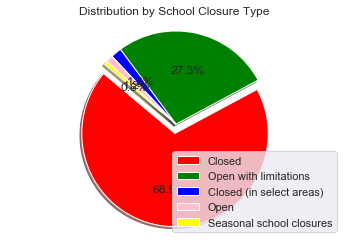

In [55]:
labelst= list(schooltype_df["Closure type"])
sizest =list(schooltype_df["School Status"])
colorst=["red", "green", "blue","pink","yellow"]
explodet=[0.1,0,0,0,0]
plt.pie(sizest, explode=explodet, colors=colorst,
        autopct="%1.1f%%", shadow=True, startangle=140, labeldistance=1.1
       )
plt.title("Distribution by School Closure Type")
plt.axis("equal")
plt.legend(labelst, loc="lower right")
plt.savefig('School Pie', dpi=400)
plt.show()



In [56]:
Open_df=comb.loc[(comb["School Status"]!="Closed") &(comb["Date"]!="2020-06-22")]
Closed_df=comb.loc[(comb["School Status"]=="Closed")&(comb["Date"]!="2020-06-22")]


In [57]:
Close_df=Closed_df[["Date", "Total Deaths Per Million"]]
Opened_df=Open_df[["Date", "Total Deaths Per Million"]]

In [58]:
Datet =list(comb["Date"].drop_duplicates())

datest=Datet

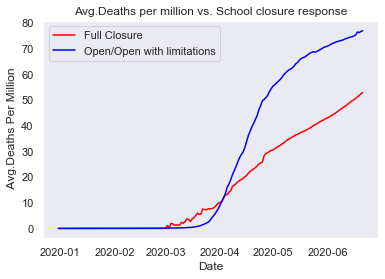

In [59]:
timet = [datetime.datetime.strptime(d,"%Y-%m-%d").date() for d in datest]
Avdeatht =Close_df.groupby("Date").mean()
Avdeathts=Opened_df.groupby("Date").mean()
axt = plt.gca()
#get axes


formatter = mdates.DateFormatter("%Y-%m")
axt.xaxis.set_major_formatter(formatter)

locator = mdates.MonthLocator()
axt.xaxis.set_major_locator(locator)

Closed, =plt.plot(timet, Avdeatht, color="red", label="Full Closure")
Open, =plt.plot(timet, Avdeathts, color="blue", label="Open/Open with limitations")
plt.legend(handles=[Closed, Open], loc="best")

plt.ylabel(" Avg.Deaths Per Million")
plt.xlabel("Date")
plt.title("Avg.Deaths per million vs. School closure response")
plt.grid()
plt.savefig('Closure Graph',dpi=400)
plt.show()

In [60]:
figt = px.scatter(tCleaned_df, x='diabetes_prevalence', y='Total Deaths Per Million',facet_col="Continent"
                 , hover_name="Country", trendline="ols", color="Continent",
                 labels={'diabetes_prevalence': "diabeties(%)"})
figt.update_layout(title='Diabetes Prevalence vs Total deaths per million')

figt.show()

In [61]:
africat_df=tCleaned_df[tCleaned_df['Continent']=="Africa"]
asiat_df=tCleaned_df[tCleaned_df['Continent']=="Asia"]
europet_df=tCleaned_df[tCleaned_df['Continent']=="Europe"]
NAt_df=tCleaned_df[tCleaned_df['Continent']=="North America"]
oceaniat_df=tCleaned_df[tCleaned_df['Continent']=="Oceania"]
SAt_df=tCleaned_df[tCleaned_df['Continent']=="South America"]

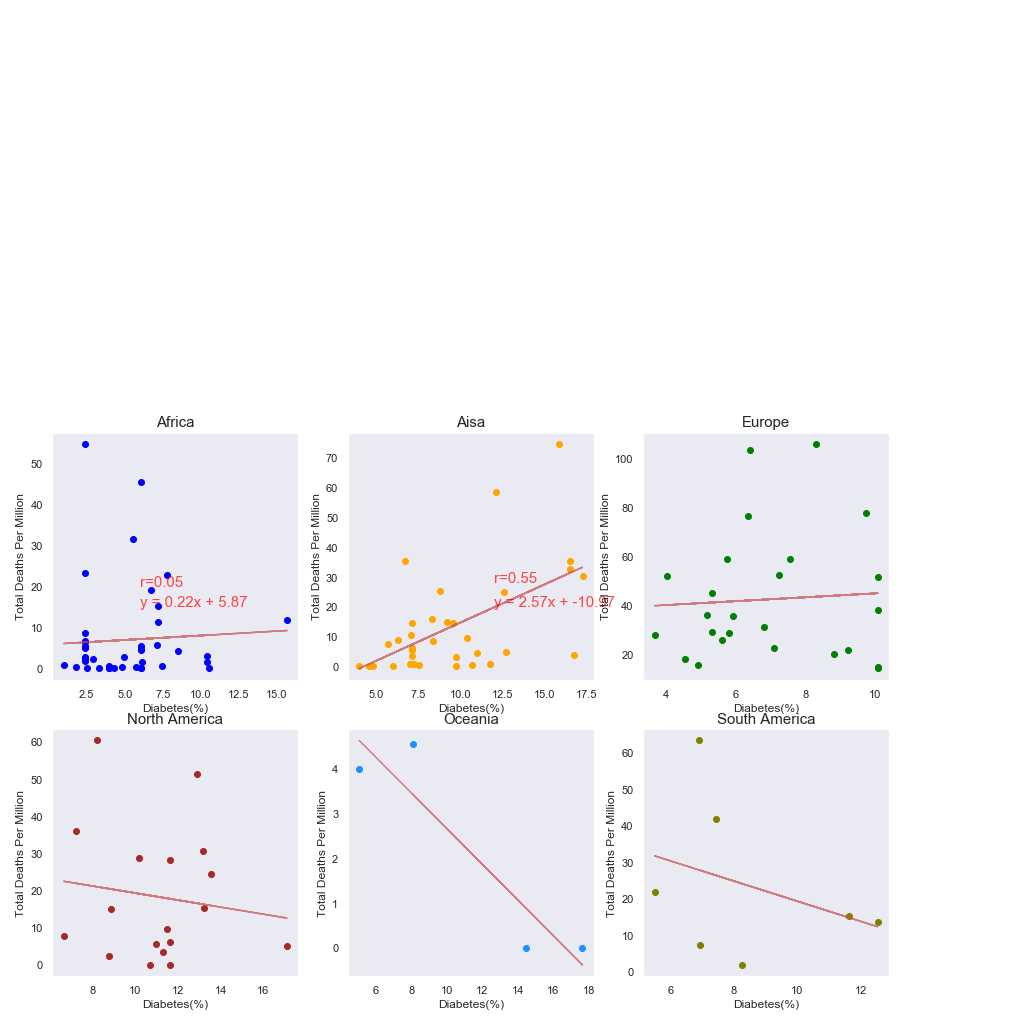

In [62]:
fig, axt = plt.subplots(2,3,figsize=(15,10))

# africa
cafricat_df=africat_df[["diabetes_prevalence","Total Deaths Per Million"]]
cafricat_df=cafricat_df.dropna()
x_values=cafricat_df["diabetes_prevalence"]
y_values=cafricat_df["Total Deaths Per Million"]
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
axt[0,0].scatter(x_values, y_values,color='blue')
axt[0,0].plot(x_values,regress_values,"r-",alpha=0.7)
axt[0,0].set_title('Africa', size=15) # Title
axt[0,0].set_xlabel('Diabetes(%)', fontsize = 12) 
axt[0,0].set_ylabel('Total Deaths Per Million', fontsize = 12) 
axt[0,0].annotate(line_eq,(6,15),fontsize=15,color="red",alpha=0.7)
correlation = st.pearsonr(x_values,y_values)
correlation_eq="r="+str(round(correlation[0],2))
axt[0,0].annotate(correlation_eq,(6,20),fontsize=15,color="red",alpha=0.7)
axt[0,0].grid()

# asia
casia_df=asiat_df[["diabetes_prevalence","Total Deaths Per Million"]]
casia_df=casia_df.dropna()
x_values=casia_df["diabetes_prevalence"]
y_values=casia_df["Total Deaths Per Million"]
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
axt[0,1].scatter(x_values, y_values,color='orange')
axt[0,1].plot(x_values,regress_values,"r-",alpha=0.7)
axt[0,1].set_title('Aisa', size=15) # Title
axt[0,1].set_xlabel('Diabetes(%)', fontsize = 12)
axt[0,1].set_ylabel('Total Deaths Per Million', fontsize = 12) 
axt[0,1].annotate(line_eq,(12,20),fontsize=15,color="red",alpha=0.7)
correlation = st.pearsonr(x_values,y_values)
correlation_eq="r="+str(round(correlation[0],2))
axt[0,1].annotate(correlation_eq,(12,28),fontsize=15,color="red",alpha=0.7)
axt[0,1].grid()

# europe
ceuropet_df=europet_df[["diabetes_prevalence","Total Deaths Per Million"]]
ceuropet_df=ceuropet_df.dropna()
x_values=ceuropet_df["diabetes_prevalence"]
y_values=ceuropet_df["Total Deaths Per Million"]
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
axt[0,2].scatter(x_values, y_values,color='green')
axt[0,2].plot(x_values,regress_values,"r-",alpha=0.7)
axt[0,2].set_title('Europe', size=15) # Title
axt[0,2].set_xlabel('Diabetes(%)', fontsize = 12)
axt[0,2].set_ylabel('Total Deaths Per Million', fontsize = 12) 
axt[0,2].annotate(line_eq,(11,200),fontsize=15,color="red",alpha=0.7)
correlation = st.pearsonr(x_values,y_values)
correlation_eq="r="+str(round(correlation[0],2))
axt[0,2].annotate(correlation_eq,(11,280),fontsize=15,color="red",alpha=0.7)
axt[0,2].grid()

# North America
CNAt_df=NAt_df[["diabetes_prevalence","Total Deaths Per Million"]]
CNAt_df=CNAt_df.dropna()
x_values=CNAt_df["diabetes_prevalence"]
y_values=CNAt_df["Total Deaths Per Million"]
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
axt[1,0].scatter(x_values, y_values,color='brown')
axt[1,0].plot(x_values,regress_values,"r-",alpha=0.7)
axt[1,0].set_title('North America', size=15) # Title
axt[1,0].set_xlabel('Diabetes(%)', fontsize = 12) 
axt[1,0].set_ylabel('Total Deaths Per Million', fontsize = 12) 
axt[1,0].annotate(line_eq,(4,75),fontsize=15,color="red",alpha=0.7)
correlation = st.pearsonr(x_values,y_values)
correlation_eq="r="+str(round(correlation[0],2))
axt[1,0].annotate(correlation_eq,(4,100),fontsize=15,color="red",alpha=0.7)
axt[1,0].grid()


#oceania
Coceaniat_df=oceaniat_df[["diabetes_prevalence","Total Deaths Per Million"]]
Coceaniat_df=Coceaniat_df.dropna()
x_values=Coceaniat_df["diabetes_prevalence"]
y_values=Coceaniat_df["Total Deaths Per Million"]
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
axt[1,1].scatter(x_values, y_values,color='dodgerblue')
axt[1,1].plot(x_values,regress_values,"r-",alpha=0.7)
axt[1,1].set_title('Oceania', size=15) # Title
axt[1,1].set_xlabel('Diabetes(%)', fontsize = 12) 
axt[1,1].set_ylabel('Total Deaths Per Million', fontsize = 12) 
axt[1,1].annotate(line_eq,(6,8),fontsize=15,color="red",alpha=0.7)
correlation = st.pearsonr(x_values,y_values)
correlation_eq="r="+str(round(correlation[0],2))
axt[1,1].annotate(correlation_eq,(6,11),fontsize=15,color="red",alpha=0.7)
axt[1,1].grid()

#south america
CSAt_df=SAt_df[["diabetes_prevalence","Total Deaths Per Million"]]
CSAt_df=CSAt_df.dropna()
x_values=CSAt_df["diabetes_prevalence"]
y_values=CSAt_df["Total Deaths Per Million"]
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
axt[1,2].scatter(x_values, y_values,color='olive')
axt[1,2].plot(x_values,regress_values,"r-",alpha=0.7)
axt[1,2].set_title('South America', size=15) # Title
axt[1,2].set_xlabel('Diabetes(%)', fontsize = 12)
axt[1,2].set_ylabel('Total Deaths Per Million', fontsize = 12) 
axt[1,2].annotate(line_eq,(8,100),fontsize=15,color="red",alpha=0.7)
correlation = st.pearsonr(x_values,y_values)
correlation_eq="r="+str(round(correlation[0],2))
axt[1,2].annotate(correlation_eq,(8,120),fontsize=15,color="red",alpha=0.7)
axt[1,2].grid()

# plt.tick_params(axis='both', which='major', labelsize=14)
plt.savefig('Diabetes Prevalence vs Total deaths per million.png', dpi=400)
plt.show()

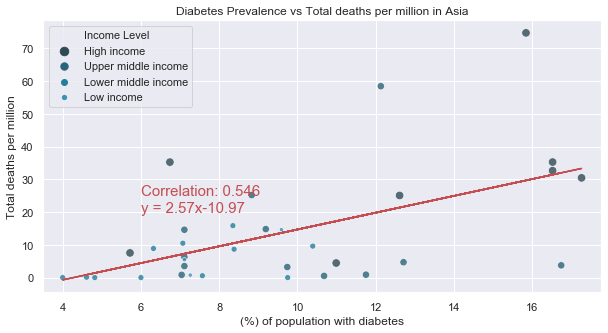

In [63]:
DB = tCleaned_df.loc[tCleaned_df["Continent"]=="Asia"]["diabetes_prevalence"]
TD = tCleaned_df.loc[tCleaned_df["Continent"]=="Asia"]['Total Deaths Per Million']
(slopet, interceptt, rvaluet, pvaluet, stderrt) = st.linregress(DB, TD)
regress_valuest = DB * slopet + interceptt
line_eq = "y = " + str(round(slopet,2)) + "x" + str(round(interceptt,2))
tCorrelation=f"Correlation: {round(rvaluet,3)}"
#plt.scatter(x_values,y_values, c=iris.target)
sns.set()
with sns.color_palette("PuBuGn_d"):
    plt.figure(figsize=(10,5))
    sns.scatterplot(DB,TD,hue=tCleaned_df["Income Level"], hue_order=["High income","Upper middle income",
                                             "Lower middle income","Low income"],alpha =0.8, 
                                    size=tCleaned_df["Income Level"], size_order=["High income","Upper middle income",
                                                                         "Lower middle income","Low income"],
                legend="brief" )
    plt.title("Diabetes Prevalence vs Total deaths per million in Asia")
    plt.plot(DB,regress_valuest,"r-")
    plt.xlabel("(%) of population with diabetes")
    plt.ylabel("Total deaths per million")
    plt.annotate(line_eq,(6,20),fontsize=15,color="r")
    plt.annotate(tCorrelation, (6, 25),fontsize=15,color="r")
    plt.xlim(DB.min()-0.5,DB.max()+0.5)
    plt.savefig("Diabetes Prevalence vs Total deaths per million in Asia", dpi=400)
    plt.show()

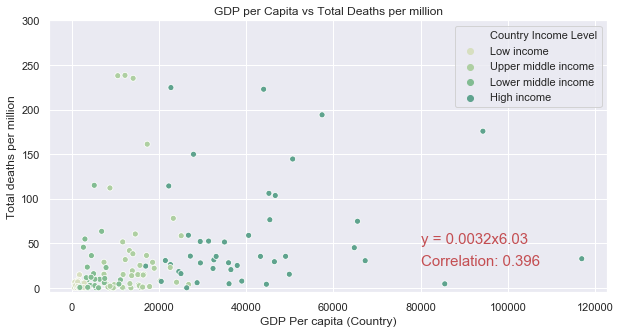

In [64]:
#Tim's Branch Ends here
#Maury's Branch Starts here
#get unique country names & get max total deaths per million/gpd/pop. density for each country
#cleaning data
max_deaths_country=  combined_df.groupby(["Country"]).agg({"Total Deaths Per Million": "max","Income Level":"unique", "Continent": "unique"})
max_pop_country=  combined_df.groupby(["Country"]).agg({"Population Density": "max"})
max_gdp_country=  combined_df.groupby(["Country"]).agg({"GDP Per Capita": "max" })
income=[]
continent=[]
max_combined_country = pd.merge(max_deaths_country,max_gdp_country, how= "outer", on = 'Country')
max_combined_country = pd.merge(max_combined_country,max_pop_country, how = 'outer', on = 'Country')
for index, row in max_combined_country.iterrows():
    x=row["Income Level"][0]
    y=row ["Continent"][0]
    income.append(x)
    continent.append(y)
max_combined_country["Country Income Level"]=income
max_combined_country["Continent"]=continent
max_combined_country_clean=max_combined_country.dropna(how = 'any')
max_combined_country_clean=max_combined_country_clean.reset_index()
max_combined_country_clean.head(20) 

sns.set()
with sns.cubehelix_palette(8, start=.5, rot=-.75,reverse=False):
    plt.figure(figsize=(10,5))
    sns.scatterplot(data= max_combined_country_clean, x="GDP Per Capita",y="Total Deaths Per Million",hue= "Country Income Level",alpha =1)
    plt.title("GDP per Capita vs Total Deaths per million")
    plt.xlabel("GDP Per capita (Country)")
    plt.ylabel("Total deaths per million")
    plt.ylim(-5,300)
    PDm = max_combined_country_clean["GDP Per Capita"]
    TDm = max_combined_country_clean['Total Deaths Per Million']
    (slopem, interceptm, rvaluem, pvaluem, stderrm) = st.linregress(PDm, TDm)
    regress_valuesm = PDm * slopem + interceptm
    line_eqm = "y = " + str(round(slopem,4)) + "x" + str(round(interceptm,2))
    Correlationm=(f"Correlation: {round(rvaluem,3)}")
    plt.annotate(line_eqm,(80000,50),fontsize=15,color="r")
    plt.annotate(Correlationm, (80000, 25),fontsize=15,color="r")
    plt.savefig("../Images/popdensityVStdpm.png")
    plt.show()

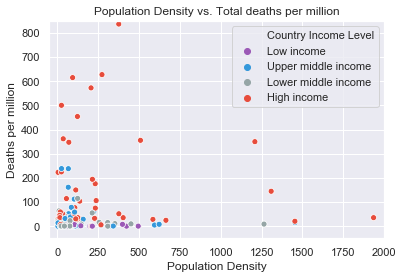

In [65]:
sns.set()
flatui = ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71"]

with sns.color_palette(flatui):
    sns.scatterplot(max_combined_country_clean["Population Density"],max_combined_country_clean["Total Deaths Per Million"], 
                    hue=max_combined_country_clean["Country Income Level"],alpha = 1, 
                    #hue_order=["Low Income", "Lower middle income","Upper middle income","High income"] 
                   )
    plt.ylim(-50, 850)
    plt.xlim(-50,2000)
    plt.title("Population Density vs. Total deaths per million")
    plt.xlabel("Population Density")
    plt.ylabel("Deaths per million")
    
    plt.show()
    
#How does population density affect Deaths per million? are lower income countries more susceptible?
fig0 = px.scatter(max_combined_country_clean,x='Population Density',y='Total Deaths Per Million',facet_col= 'Country Income Level'
                , hover_name= "Country",color= "Continent", width = 1500)
fig0.update_layout(title="Population Density vs. Total deaths per million", )
fig0.update_yaxes(range=[-2, 700])
fig0.update_xaxes(range=[-50, 2000])
fig0.write_image("../Images/Totaldeathsbyincomelvl.png")
fig0.show()

#This graph shows that population density does not affect Total Deaths Per Million 
#in lower income countries compared to higher income countries
#possibly because higher income countries are more touristic and/or because of a wide income inquality = poor people with poor hygiene transmitting the virus?

In [71]:
#Does GDP affect the spread of Covid-19?

PDm = max_combined_country_clean["GDP Per Capita"]
TDm = max_combined_country_clean['Total Deaths Per Million']
(slopem, interceptm, rvaluem, pvaluem, stderrm) = st.linregress(PDm, TDm)
regress_valuesm = PDm * slopem + interceptm
line_eqm = "y = " + str(round(slopem,2)) + "x" + str(round(interceptm,2))
Correlationm=f"Correlation: {round(rvaluem,3)}"
print(Correlationm)
fig2 = px.scatter(max_combined_country_clean,x='GDP Per Capita',y='Total Deaths Per Million'
                , hover_name= "Country", width = 1500, trendline= "ols")
fig2.update_layout(title="GDP Per Capita vs. Total deaths per million", )
fig2.update_xaxes(range=[-50, 120000])
fig2.write_image("../Images/GDPvsTDPM.png")

Correlation: 0.396


In [73]:
#plot Box plots for TDPM by Continent
df = max_combined_country_clean
fig3 = px.box(df, x="Continent", y="Total Deaths Per Million"
             , hover_name= "Country"
             , color= "Continent"
            )
fig3.write_image("../Images/TDPMboxplot.png")
fig3.show()

quartilesm = max_combined_country_clean['Total Deaths Per Million'].quantile([.25,.5,.75])
lowerqm = quartilesm[0.25]
upperqm = quartilesm[0.75]
iqrm = upperqm-lowerqm

lower_boundm = lowerqm - (1.5*iqrm)
upper_boundm = upperqm + (1.5*iqrm)

quartilestm1 = max_combined_country_clean['Population Density'].quantile([.25,.5,.75])
lowerqm1 = quartilestm1[0.25]
upperqm1 = quartilestm1[0.75]
iqrm1 = upperqm1-lowerqm1

lower_boundmm1 = lowerqm1 - (1.5*iqrm1)
upper_boundmm1 = upperqm1 + (1.5*iqrm1)

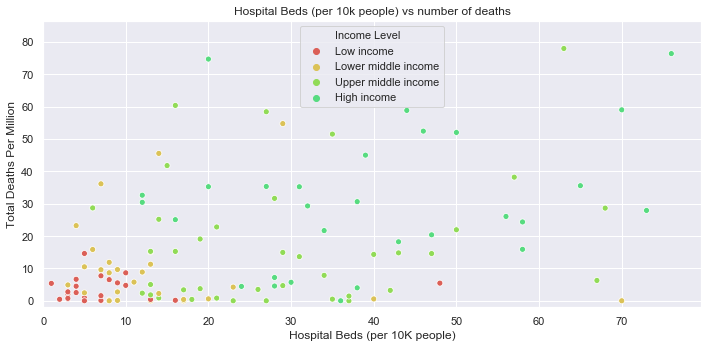

The number of hospital beds per 10k people has a weak positive correlation with the total deaths per million of 0.438163671570718


In [68]:
#Emily's Part Begins 

#Number Hospital Beds is based on the lastest year per Country

who_df = data.iloc[data.groupby("Country")["Year"].agg(pd.Series.idxmax)]
who_df.reset_index(drop=True).set_index("Country")
who_df=who_df.rename(columns={"Hospital beds (per 10 000 population)":"Hospital Beds (per 10K people)"})
hospital_beds_df=who_df.drop(["Year"], axis=1)

hospital_beds_df.head()

sorted_date_df = updated_world_df.loc[updated_world_df["Date"] == "2020-06-21"]
sorted_date_df.head()

beds_vs_deaths = pd.merge(hospital_beds_df, sorted_date_df, on = "Country")
complete_data = pd.merge(beds_vs_deaths, income_df, on = "Country")
complete_data.head()

#removing outliers from view 
beds_q1 = complete_data["Hospital Beds (per 10K people)"].quantile(0.25)
beds_q3 = complete_data["Hospital Beds (per 10K people)"].quantile(0.75)
beds_iqr = beds_q3 - beds_q1
beds_lowerbound = beds_q1 - (1.5 * beds_iqr)
beds_upperbound = beds_q3 + (1.5 * beds_iqr)


deaths_q1 = complete_data["Total Deaths Per Million"].quantile(0.25)
deaths_q3 = complete_data["Total Deaths Per Million"].quantile(0.75)
deaths_iqr = deaths_q3 - deaths_q1
deaths_lowerbound = deaths_q1 - (1.5 *deaths_iqr)
deaths_upperbound = deaths_q3 + (1.5 * deaths_iqr)

indexnames = complete_data[complete_data["Total Deaths Per Million"] >= deaths_upperbound].index
dropped_outliers_df = complete_data.drop(indexnames, inplace = True)

indexnames2 = complete_data[complete_data["Hospital Beds (per 10K people)"] >= beds_upperbound].index
dropped_outliers2_df = complete_data.drop(indexnames2, inplace = True)

sns.set()
with sns.color_palette("hls", 8):
    plt.figure(figsize=(10,5))
    sns.scatterplot(data = complete_data, x = "Hospital Beds (per 10K people)", y = "Total Deaths Per Million", hue = "Income Level", hue_order = ["Low income", "Lower middle income", "Upper middle income", "High income"])
    plt.title("Hospital Beds (per 10k people) vs number of deaths")
    plt.xlim(0,beds_upperbound)
    plt.ylim(-2 ,deaths_upperbound)
    plt.tight_layout()
    plt.savefig("../Images/hospitalbedsVSdeaths.png")
    plt.show()

#sns.regplot(x = complete_data["Hospital Beds (per 10K people)"], y = complete_data["Total Deaths Per Million"])
    
correlation = st.pearsonr(complete_data["Hospital Beds (per 10K people)"],complete_data["Total Deaths Per Million"])
print(f"The number of hospital beds per 10k people has a weak positive correlation with the total deaths per million of {correlation[0]}")
#complete_data.head()


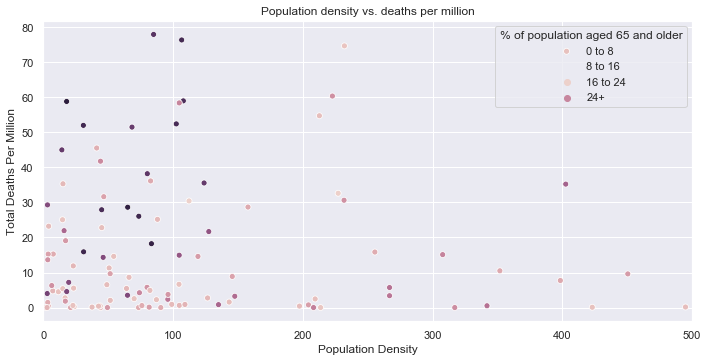

In [69]:
complete_data.head()

sns.set()
with sns.color_palette("hls", 8):
    plt.figure(figsize=(10,5))
    sns.scatterplot(data = complete_data, x = "Population Density", y = "Total Deaths Per Million", hue = "Aged 65 or older")
    plt.xlim(0,500)
    plt.tight_layout()
    plt.legend(["0 to 8", "8 to 16", "16 to 24", "24+"], title = "% of population aged 65 and older"
               ,fancybox = True
              )
    plt.title("Population density vs. deaths per million")
    plt.savefig("../Images/65plusVStdpm.png")
    plt.show()
#complete_data.head()

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


 The correlation of the % of population that smokes and the total deaths per million is 0.16243387154438688, demonstrating no relationship between the two variables


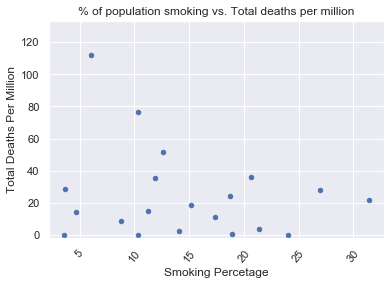

In [70]:
#Smoking Percentage is based on the lastest year per Country

smokingdata = pd.read_csv("../Resources/smokingdata.csv")

smokingdata_df = smokingdata.iloc[smokingdata.groupby("Country")["Year"].agg(pd.Series.idxmax)]

clean_smoking_data = smokingdata_df.drop(["Estimate of current cigarette smoking prevalence (%).1", "Estimate of current cigarette smoking prevalence (%).2", 
                                       "Estimate of current tobacco smoking prevalence (%)", "Estimate of current tobacco smoking prevalence (%).1", 
                                       "Estimate of current tobacco smoking prevalence (%).2", "Estimate of current tobacco use prevalence (%)", 
                                       "Estimate of current tobacco use prevalence (%).1", "Estimate of current tobacco use prevalence (%).2"], axis=1)

clean_smoking_data=clean_smoking_data.rename(columns={"Estimate of current cigarette smoking prevalence (%)":"Smoking Prevalence (%)"})
smoking_data = clean_smoking_data
smoking_prevalence=list(smoking_data["Smoking Prevalence (%)"])
smoking_percentage=[]

for x in smoking_prevalence:
    y=x.split("[")
    smoking_percentage.append(y[0])
    

    
column_values = pd.Series(smoking_percentage)
smoking_data.insert(loc=2, column="Smoking Percetage", value=column_values)
smoking_year_df=smoking_data.drop(["Smoking Prevalence (%)"], axis=1)

smoking_df=smoking_year_df.drop(["Year"], axis=1)

smoking_df.head()

smoking_vs_deaths = pd.merge(smoking_df, sorted_date_df, on = "Country")
clean_smoking_vs_deaths = smoking_vs_deaths.dropna(subset = ["Smoking Percetage"])


#remove outliers 

smoking_vs_deaths = pd.merge(smoking_df, sorted_date_df, on = "Country")
clean_smoking_vs_deaths = smoking_vs_deaths.dropna(subset = ["Smoking Percetage"])

#clean_smoking_vs_deaths.head()

#remove outliers 
clean_clean_smoking_vs_deaths = clean_smoking_vs_deaths.sort_values(by = "Smoking Percetage", ascending = True)
clean_clean_smoking_vs_deaths["Smoking Percetage"] = pd.to_numeric(clean_clean_smoking_vs_deaths["Smoking Percetage"], downcast = "float")


deaths2_q1 = clean_clean_smoking_vs_deaths["Total Deaths Per Million"].quantile(0.25)
deaths2_q3 = clean_clean_smoking_vs_deaths["Total Deaths Per Million"].quantile(0.75)
deaths2_iqr = deaths2_q3 - deaths2_q1
deaths2_lowerbound = deaths2_q1 - (1.5 *deaths2_iqr)
deaths2_upperbound = deaths2_q3 + (1.5 * deaths2_iqr)



clean_clean_smoking_vs_deaths.plot(kind = "scatter", x = "Smoking Percetage", y ="Total Deaths Per Million")
plt.xticks(rotation=50)
plt.title("% of population smoking vs. Total deaths per million")
plt.ylim(-2, deaths2_upperbound)
plt.savefig("../Images/smokingVStdpm.png")

#regression line 
#turn Smoking percentage into float 
correlation = st.pearsonr(clean_clean_smoking_vs_deaths["Smoking Percetage"],clean_clean_smoking_vs_deaths["Total Deaths Per Million"])
print(f" The correlation of the % of population that smokes and the total deaths per million is {correlation[0]}, demonstrating no relationship between the two variables")